# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the final version...

## Finding the best models
- [x] [Exploring the data](#explore)
- [x] [Which training sample is best?](#sample)
- [x] [Which image representation is best?](#repr)
- [x] [Which channel configuration is best?](#channel)
- [x] [Which categorisation is best?](#cat)
- [x] [Does vertex help cosmic classifier?](#cosmic)
- [x] [Does primary count help beam classifier?](#beam)
- [x] [Does lepton energy help neutrino energy estimation?](#energy)
- [x] [Different sample energy estimation](#energy_samples)
- [ ] [Final performance and comparison with old reco/pid](#final)

## Explainability and resilience
- [ ] [Model calibration sensitivity: factor](#calib_factor)
- [ ] [Model calibration sensitivity: abs](#calib_abs)
- [ ] [Model calibration sensitivity: noise](#calib_noise)
- [x] [Clustering: cosmic classification](#cosmic_cluster)
- [x] [Clustering: beam classification](#beam_cluster)
- [x] [Explanation: cosmic/beam/energy](#explain)
- [x] [Different height detectors](#heights)
- [x] [Without light cones](#lcs)

In [1]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "./config/analysis/config.yaml"
save_path = "./data/output/"
nuel_map_file = "/unix/chips/jtingey/production/beam_all/nuel/map/chips_1200_old/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/production/beam_all/numu/map/chips_1200_old/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/production/cosmic_all/map/chips_1200_old/selected_000_sim_map.root"
old_nuel_file = "./data/input/el_all_output.root"
old_numu_file = "./data/input/mu_all_output.root"
total_flux_events = 1968000
total_uniform_events = 3500000 # 3780000
total_cosmic_events = 1975000

In [2]:
# Standard inports
import os
import logging
import importlib
import copy

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import mplhep as hep
import uproot

# Setup Tensorflow with correct logging and GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
import chipsnet.plotting

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}
plt.style.use([hep.style.ROOT, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
config = chipsnet.config.get(config_path)
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    importlib.reload(chipsnet.plotting)
    config = chipsnet.config.get(config_path)

# Finding the best models

<a id='explore'></a>

## Exploring the data (explore)

In [4]:
s_both_ev, s_both_out = chipsnet.utils.evaluate(config, "sample_both")
s_flux_ev, s_flux_out = chipsnet.utils.evaluate(config, "sample_flux")
s_uniform_ev, s_uniform_out = chipsnet.utils.evaluate(config, "sample_uniform")
flux_ev, flux_out = chipsnet.utils.evaluate(config, "flux")


************************ Evaluating sample_both ************************
Weights: (0,0.00000), (0,0.00000), (64006,0.05239), (0,0.00000), (0,0.00000)
Cuts:    (43195,0.95615), (41751,0.92500), (25765,0.68364), (0,0.00000)
took 87.28 seconds

************************ Evaluating sample_flux ************************
Weights: (0,0.00000), (0,0.00000), (63866,0.05250), (0,0.00000), (0,0.00000)
Cuts:    (52744,0.94730), (50482,0.91523), (11335,0.66039), (0,0.00000)
took 97.52 seconds

************************ Evaluating sample_uniform ************************
Weights: (0,0.00000), (0,0.00000), (64001,0.05239), (0,0.00000), (0,0.00000)
Cuts:    (38056,0.96164), (36816,0.93035), (33796,0.69178), (0,0.00000)
took 105.79 seconds

************************ Evaluating flux ************************
Weights: (6831,0.00569), (6828,0.00037), (53622,0.06253), (6833,0.01074), (0,0.00000)
Cuts:    (55421,0.95189), (47886,0.91795), (11759,0.66767), (0,0.00000)
took 114.63 seconds


In [39]:
flux_ev[(flux_ev.t_comb_cat == 0) & (flux_ev.t_sample_type == 0)]["w"].sum()

35.042659662877035

In [40]:
flux_ev[(flux_ev.t_comb_cat == 0) & (flux_ev.t_sample_type == 1)]["w"].sum()

44.059508957725605

In [5]:
# Get oscillation arrays...
vac_osc_file_zero = uproot.open("./data/input/oscillations/vac_osc_cp_zero.root")
vac_osc_file_plus = uproot.open("./data/input/oscillations/vac_osc_cp_plushalfpi.root")
vac_osc_file_minus = uproot.open("./data/input/oscillations/vac_osc_cp_minushalfpi.root")
matter_osc_file_zero = uproot.open("./data/input/oscillations/matter_osc_cp_zero.root")
matter_osc_file_plus = uproot.open("./data/input/oscillations/matter_osc_cp_plushalfpi.root")
matter_osc_file_minus = uproot.open("./data/input/oscillations/matter_osc_cp_minushalfpi.root")

vac_numu_prop_zero = vac_osc_file_zero["hist_mumu"].values[113]
vac_nuel_prop_zero = vac_osc_file_zero["hist_mue"].values[113]
vac_numu_prop_plus = vac_osc_file_plus["hist_mumu"].values[113]
vac_nuel_prop_plus = vac_osc_file_plus["hist_mue"].values[113]
vac_numu_prop_minus = vac_osc_file_minus["hist_mumu"].values[113]
vac_nuel_prop_minus = vac_osc_file_minus["hist_mue"].values[113]

matter_numu_prop_zero = matter_osc_file_zero["hist_mumu"].values
matter_nuel_prop_zero = matter_osc_file_zero["hist_mue"].values
matter_numu_prop_plus = matter_osc_file_plus["hist_mumu"].values
matter_nuel_prop_plus = matter_osc_file_plus["hist_mue"].values
matter_numu_prop_minus = matter_osc_file_minus["hist_mumu"].values
matter_nuel_prop_minus = matter_osc_file_minus["hist_mue"].values

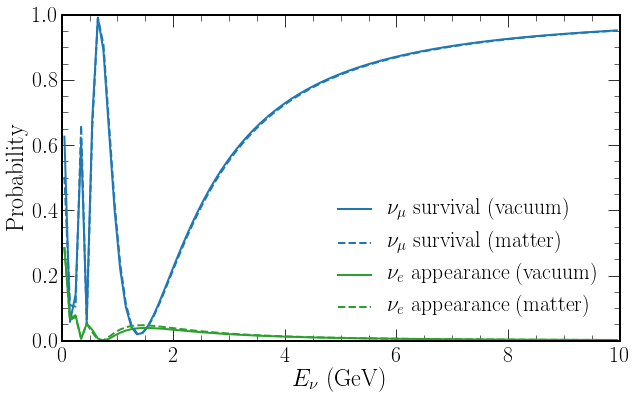

In [6]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(10, 6), gridspec_kw={"hspace": 0.3})
axs.plot(energies, vac_numu_prop_zero, color="tab:blue", linewidth=2)
axs.plot(energies, vac_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_numu_prop_zero, color="tab:blue", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2, linestyle="dashed")
axs.set_ylim(0, 1)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=24)
axs.set_ylabel(r"Probability", fontsize=24)
vac_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$\nu_{\mu}$ survival (vacuum)")
vac_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\nu_{e}$ appearance (vacuum)")
matter_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="dashed", label=r"$\nu_{\mu}$ survival (matter)")
matter_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\nu_{e}$ appearance (matter)")
axs.legend(handles=[vac_numu, matter_numu, vac_nuel, matter_nuel], loc="lower right")
chipsnet.plotting.save(save_path + "explore_osc_vac_vs_matter_probs")

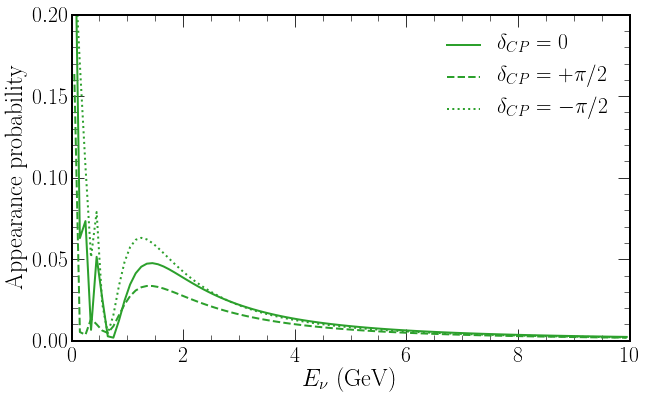

In [7]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(10, 6), gridspec_kw={"hspace": 0.3})
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_nuel_prop_plus, color="tab:green", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_minus, color="tab:green", linewidth=2, linestyle="dotted")
axs.set_ylim(0, 0.2)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=24)
axs.set_ylabel(r"Appearance probability", fontsize=24)
zero_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\delta_{CP}=0$")
plus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\delta_{CP}=+\pi/2$")
minus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dotted", label=r"$\delta_{CP}=-\pi/2$")
axs.legend(handles=[zero_cp, plus_cp, minus_cp], loc="upper right")
chipsnet.plotting.save(save_path + "explore_osc_cp_probs")

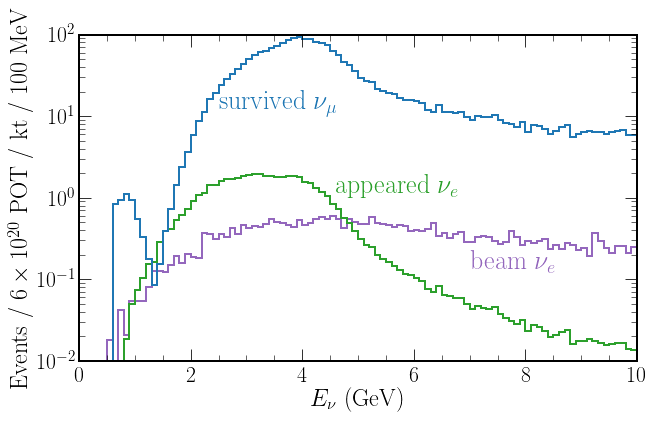

In [19]:
nuel_ev = flux_ev[
    (flux_ev[chipsnet.data.MAP_NU_TYPE["name"]] == 0) & 
    (flux_ev[chipsnet.data.MAP_COSMIC_CAT["name"]] == 0) &
    (flux_ev["t_sample_type"] == 0)
]
osc_nuel_ev = flux_ev[
    (flux_ev[chipsnet.data.MAP_NU_TYPE["name"]] == 0) & 
    (flux_ev[chipsnet.data.MAP_COSMIC_CAT["name"]] == 0) &
    (flux_ev["t_sample_type"] == 1)
]
numu_ev = flux_ev[
    (flux_ev[chipsnet.data.MAP_NU_TYPE["name"]] == 1) &
    (flux_ev[chipsnet.data.MAP_COSMIC_CAT["name"]] == 0) &
    (flux_ev["t_sample_type"] == 0)
]

fig, axs = plt.subplots(1, 1, figsize=(10, 6), gridspec_kw={"hspace": 0.3})
axs.hist(nuel_ev["t_nu_energy"]/1000, weights=nuel_ev["w"], range=(0, 10), bins=100, color='tab:purple', histtype='step', linewidth=2)
axs.hist(osc_nuel_ev["t_nu_energy"]/1000, weights=osc_nuel_ev["w"], range=(0, 10), bins=100, color='tab:green', histtype='step', linewidth=2)
axs.hist(numu_ev["t_nu_energy"]/1000, weights=numu_ev["w"], range=(0, 10), bins=100, color='tab:blue', histtype='step', linewidth=2)
axs.text(2.5, 11, r"survived $\nu_{\mu}$", color='tab:blue')
axs.text(4.6, 1, r"appeared $\nu_{e}$", color='tab:green')
axs.text(7, 0.12, r"beam $\nu_{e}$", color='tab:purple')
axs.set_yscale('log')
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=24)
axs.set_ylabel(r"Events / $6\times10^{20}$ POT / kt / 100 MeV", fontsize=24)
axs.set_ylim(10e-3, 10e1)
chipsnet.plotting.save(save_path + "explore_osc_fluxes")

In [20]:
def plot_training_sample(events, scale, save_name):
    data = [
        len(events[events["t_nu_nc_cat"] == i])
        for i in range(len(chipsnet.data.MAP_NU_NC_COMB_CAT["labels"]))
    ]
    data = [x * scale for x in data]

    labels = chipsnet.data.MAP_NU_NC_COMB_CAT["labels"]
    cats = np.arange(len(labels))
    width = 1

    fig, axs = plt.subplots(1, 1, figsize=(12, 5), gridspec_kw={"hspace": 0.3})
    axs.bar(cats, data, color="tab:blue", width=width, label="training sample", edgecolor='black')
    axs.set_xticks(cats)
    axs.set_xticklabels(labels, fontsize=18, rotation="vertical")
    axs.set_ylabel("Training events")
    axs.set_yscale('log')
    axs.set_ylim(10e2, 10e6)
    chipsnet.plotting.save(save_name)

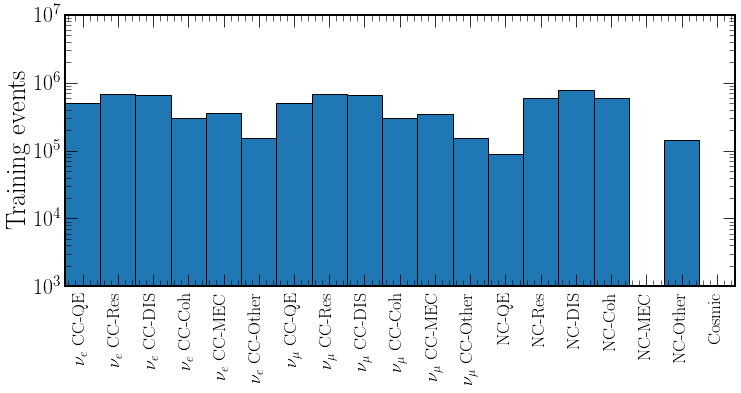

In [21]:
plot_training_sample(s_both_ev, (total_flux_events+total_uniform_events+total_cosmic_events) / config.eval.examples, save_path + "explore_both_sample")

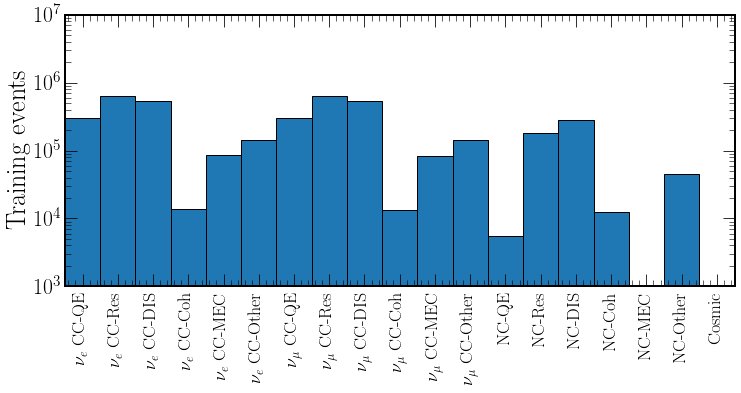

In [22]:
plot_training_sample(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, save_path + "explore_flux_sample")

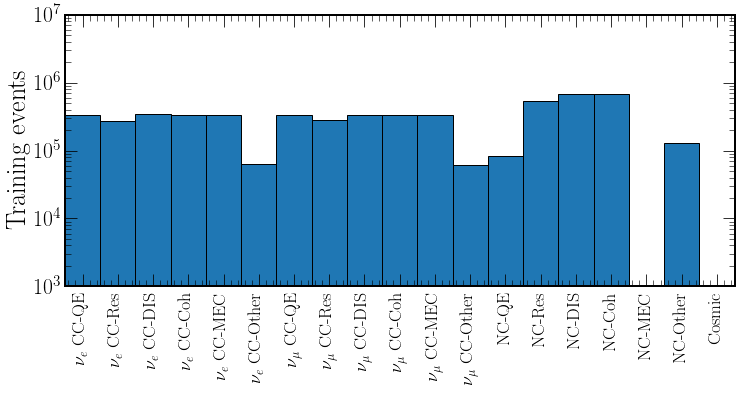

In [23]:
plot_training_sample(s_uniform_ev, (total_uniform_events+total_cosmic_events) / config.eval.examples, save_path + "explore_uniform_sample")

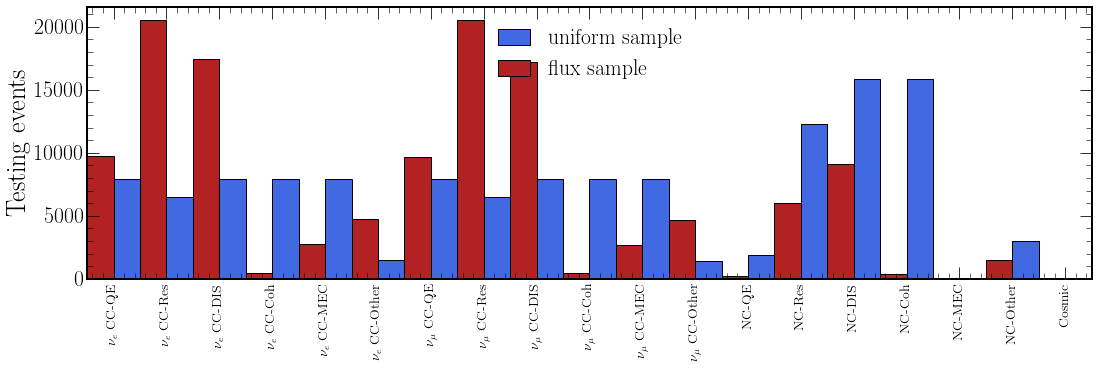

In [24]:
chipsnet.plotting.plot_cats(s_uniform_ev, s_flux_ev, chipsnet.data.MAP_NU_NC_COMB_CAT, save_path)

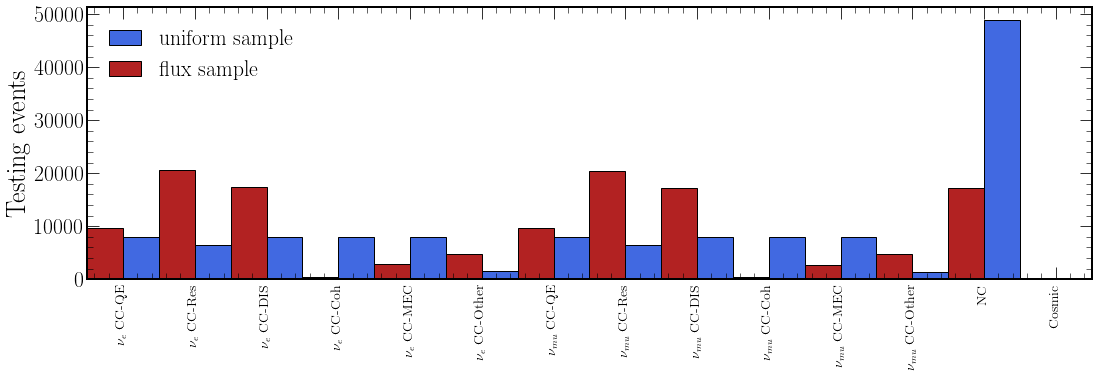

In [25]:
chipsnet.plotting.plot_cats(s_uniform_ev, s_flux_ev, chipsnet.data.MAP_NC_COMB_CAT, save_path)

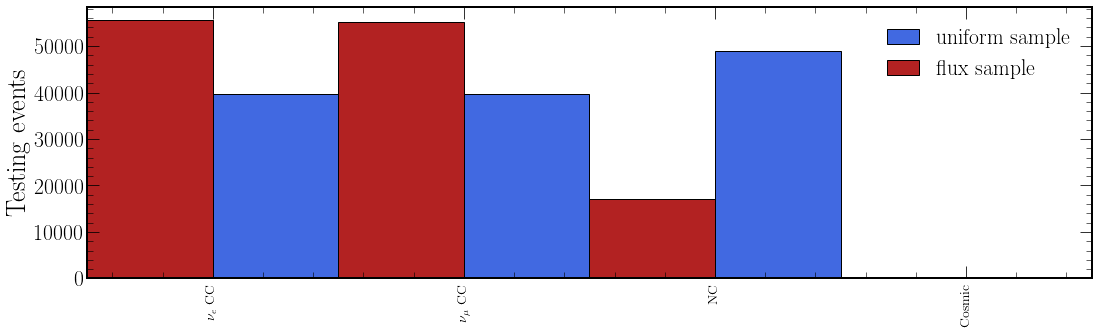

In [26]:
chipsnet.plotting.plot_cats(s_uniform_ev, s_flux_ev, chipsnet.data.MAP_FULL_COMB_CAT, save_path)

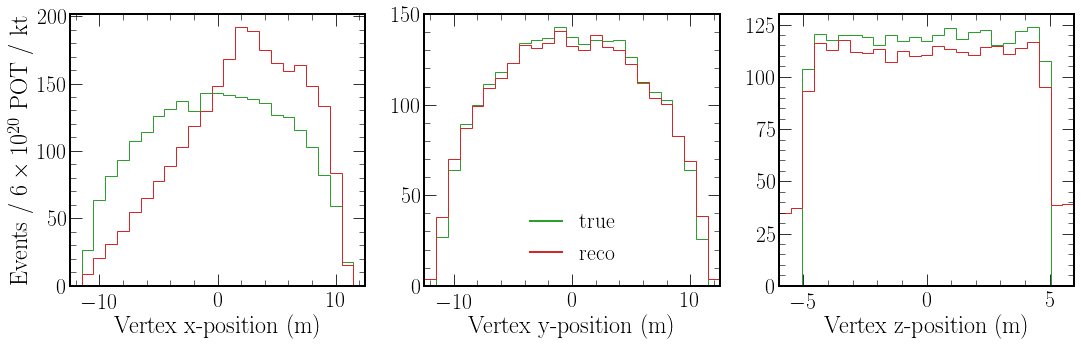

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100, 
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[0].set_xlabel('Vertex x-position (m)', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)
single = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label="true")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label="reco")
axs[1].legend(handles=[single, multi], loc="lower center")

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100,
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[1].set_xlabel('Vertex y-position (m)', fontsize=24)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100,
            range=(-6, 6), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100, 
            range=(-6, 6), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[2].set_xlabel('Vertex z-position (m)', fontsize=24)
chipsnet.plotting.save(save_path + "explore_vtx_positions")

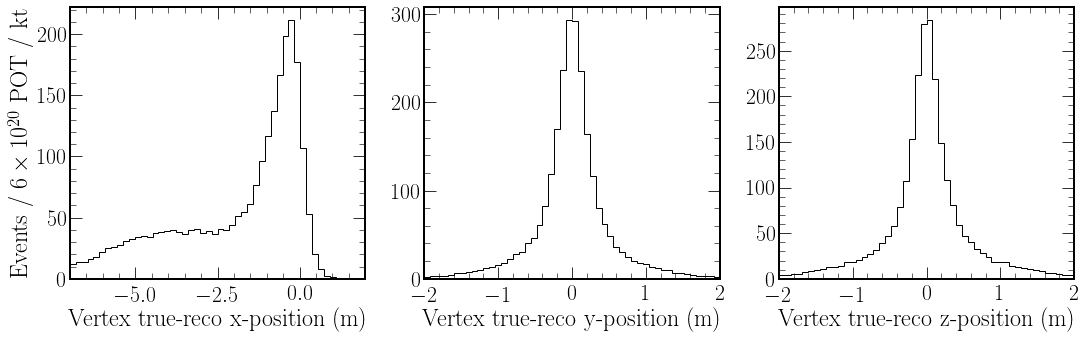

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-7, 2), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=24)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100), 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=24)
chipsnet.plotting.save(save_path + "explore_true_reco_vtx")

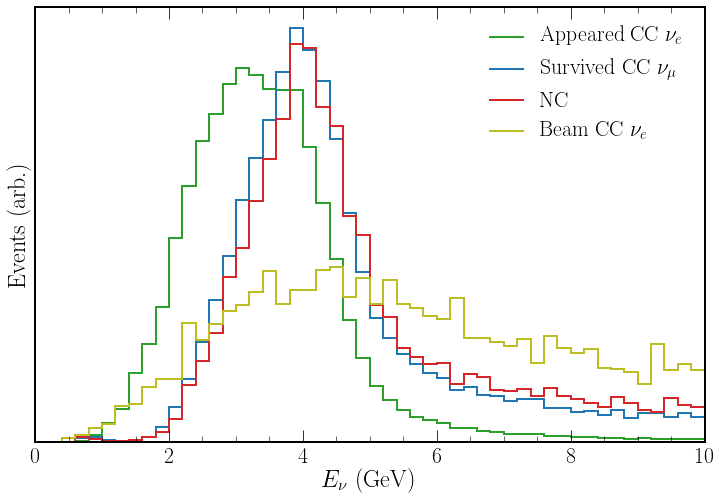

In [43]:
osc_nuel = matplotlib.lines.Line2D([], [], c='tab:green', linewidth=2)
numu = matplotlib.lines.Line2D([], [], c='tab:blue', linewidth=2)
nc = matplotlib.lines.Line2D([], [], c='tab:red', linewidth=2)
nuel = matplotlib.lines.Line2D([], [], c='tab:olive', linewidth=2)

fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.3})
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["w"],
         range=(0, 10), bins=50, color='tab:green', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"],
         range=(0, 10), bins=50, color='tab:blue', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"],
         range=(0, 10), bins=50, color='tab:red', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["w"],
         range=(0, 10), bins=50, color='tab:olive', histtype='step', density=True, linewidth=2)
axs.legend(loc="upper right", handles=[osc_nuel, numu, nc, nuel], labels=[r"Appeared CC $\nu_{e}$", r"Survived CC $\nu_{\mu}$", r"NC", r"Beam CC $\nu_{e}$"])
axs.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=24)
axs.set_ylabel('Events (arb.)', fontsize=24)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
chipsnet.plotting.save(save_path + "explore_nu_energies")

In [ ]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_charge_map_origin": [], "r_charge_map_iso": [], "r_charge_map_vtx": [],
               "r_time_map_origin": [], "r_time_map_iso": [], "r_time_map_vtx": [], "r_hough_map_vtx": []}
true_dict = {"t_code": [], "t_nuEnergy": [], "t_p_pdgs": [], "t_p_energies": []}
               
# Load the images into the dictionary
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))
for truth_info in true_dict.keys():
    true_dict[truth_info].extend(nuel_file['true'].array(truth_info))
    true_dict[truth_info].extend(numu_file['true'].array(truth_info))
    true_dict[truth_info].extend(cosmic_file['true'].array(truth_info))    

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

In [ ]:
event_num = 41
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_nuel_ccqel_event")

In [ ]:
event_num = 2037
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, 2037, save_path+"explore_numu_ccdis_event")

In [ ]:
event_num = 4017
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, 4017, save_path+"explore_cosmic_event")

In [ ]:
event_num = 2031
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, 2031, save_path+"explore_numu_ncdis_event")

In [ ]:
chipsnet.plotting.plot_hough(images_dict, [41, 2037, 2031], save_path+"explore_hough_events")

In [ ]:
chipsnet.plotting.plot_8bit_range(images_dict, save_path=save_path)

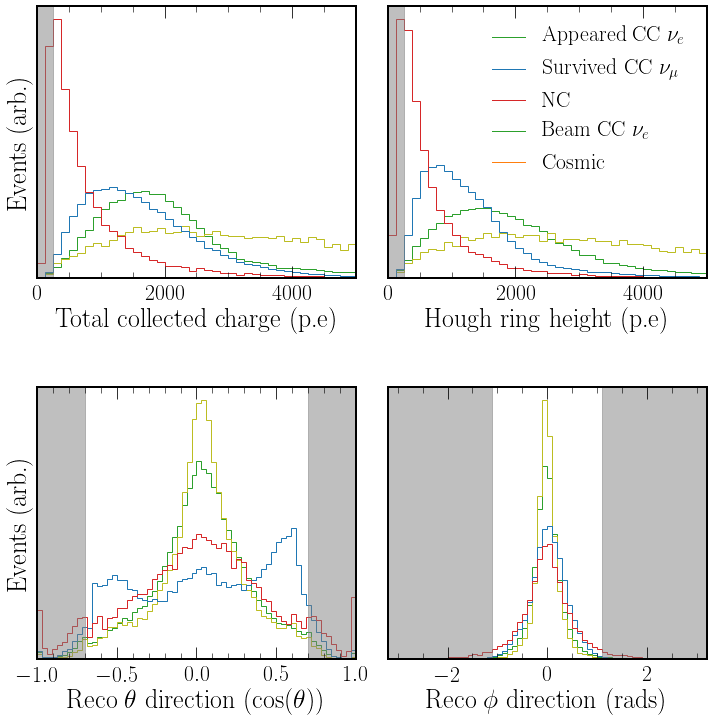

In [37]:
chipsnet.plotting.plot_cuts(config, flux_ev, save_path)

In [ ]:
# Tidy up
del s_both_ev, s_both_out
del s_flux_ev, s_flux_out
del s_uniform_ev, s_uniform_out
del flux_ev, flux_out
del images_dict
del numu_ev, nuel_e, osc_nuel_ev

<a id='sample'></a>

## Which training sample is best? (sample)
* The training sample you use and its relative number of events for each category makes a significant difference to performance.
* As expected training on a beam flux distribution is much better than a uniform sample.
* Bolstering the underepresented categories in the beam flux however leads to much better performance in seperating CC and NC types.

In [4]:
ev, outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["sample_both", "sample_flux", "sample_uniform"],
    ["t_all_cat", "t_all_cat", "t_all_cat"]
)


************************ Evaluating flux ************************
Weights: (17296,0.00225), (17293,0.00015), (101923,0.03290), (17298,0.00424), (0,0.00000)
Cuts:    (112080,0.95057), (94508,0.91796), (23721,0.67508), (0,0.00000)

------------------------ sample_both report ------------------------
- Comb-> Prec: (0.93828,0.69754), Rec: (0.90414,0.86667), F1: (0.91636,0.74366)
- Cat->  Prec: (0.58139,0.33515), Rec: (0.49187,0.44026), F1: (0.50580,0.30660)

- Nuel-> ROC-AUC: 0.81817, PRC-AUC: 0.60720, S-Eff: 0.82503, S-Pur: 0.37451
- FOM1-> 0.37220, 0.83500, 53.35671, 23.39246, 19.64557, 0.67243, 0.55352
- FOM2-> 8.93972, 0.95000, 35.61651, 8.30490, 7.56795, 0.44886, 0.69173

- Numu-> ROC-AUC: 0.66707, PRC-AUC: 0.91936, S-Eff: 0.84963, S-Pur: 0.99377
- FOM1-> 0.86793, 0.08000, 4.21491, 1829.20660, 49.86477, 0.89359, 0.97128
- FOM2-> 2375.63173, 0.99500, 0.03837, 1421.20749, 0.31953, 0.69428, 0.99975


------------------------ sample_flux report ------------------------
- Comb-> Prec: (0

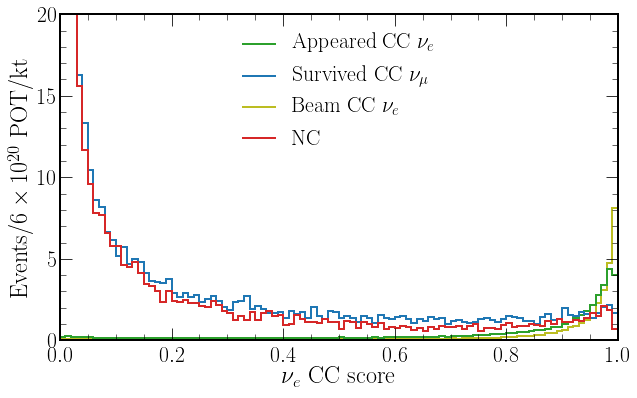

In [5]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_both_", save_path+"sample_both_output_values")

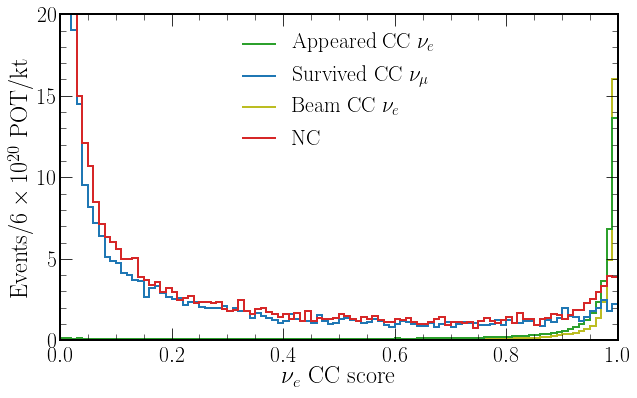

In [6]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_flux_", save_path+"sample_flux_output_values")

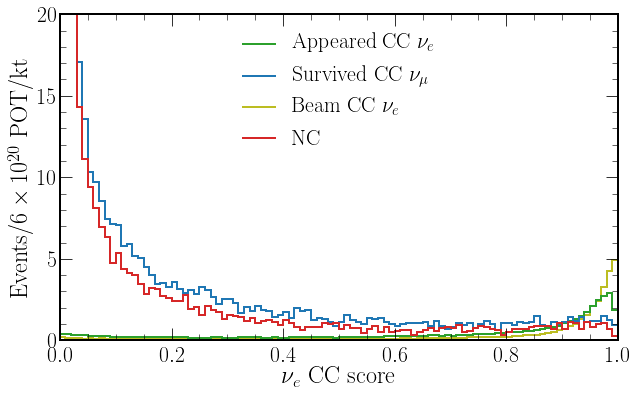

In [7]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_uniform_", save_path+"sample_uniform_output_values")

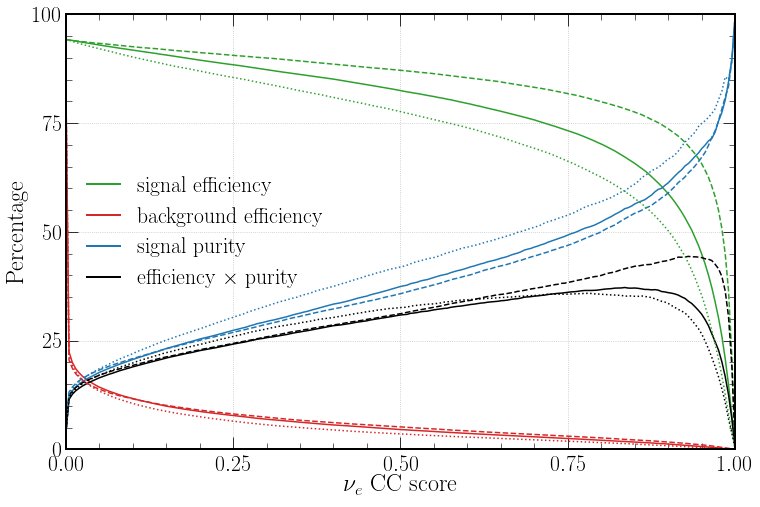

In [8]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"sample_nuel_eff_curves")

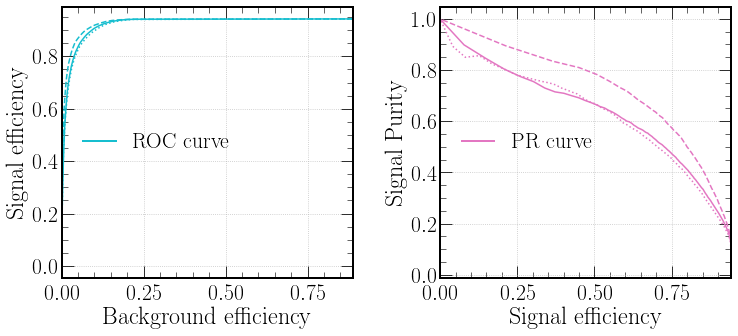

In [9]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"sample_nuel_comp_curves")

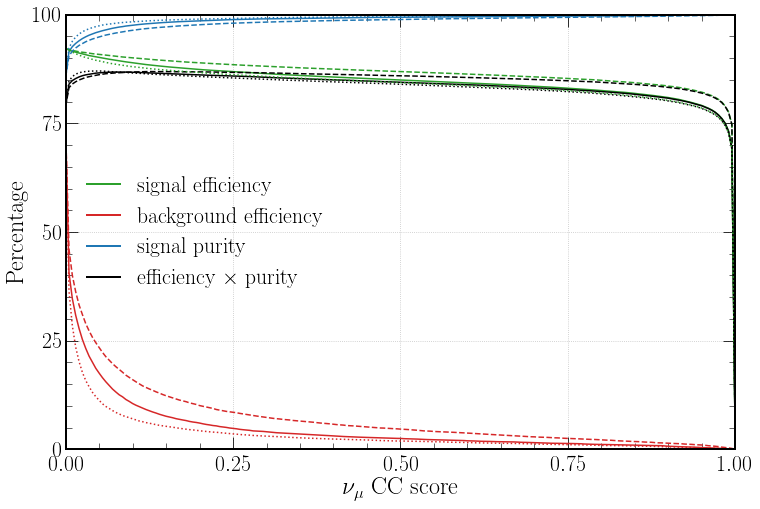

In [10]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"sample_numu_eff_curves")

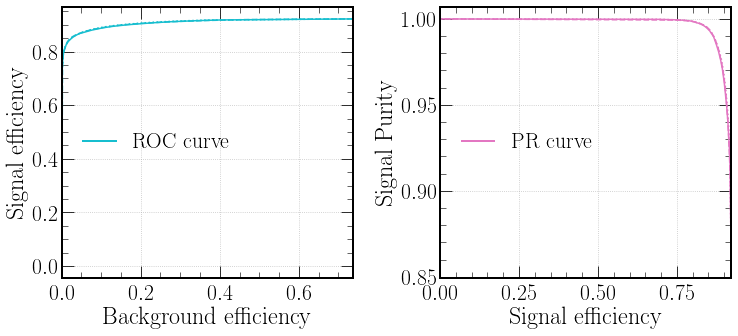

In [11]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"sample_numu_comp_curves")

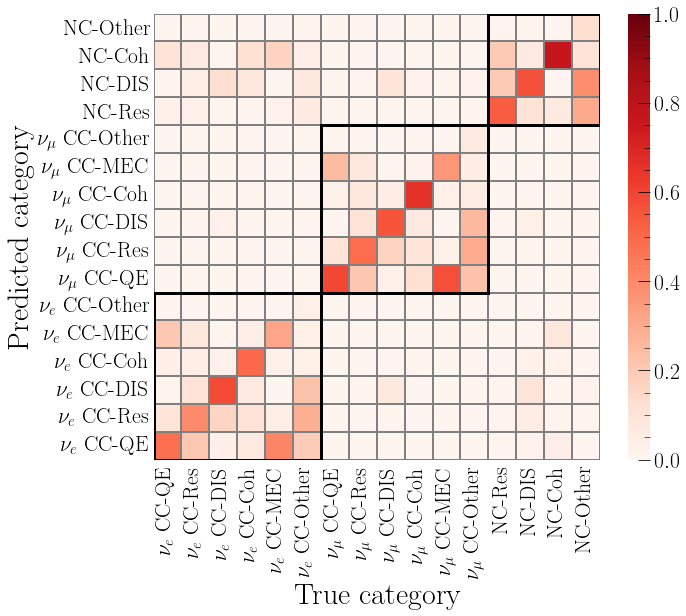

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[0]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_both_matrix")

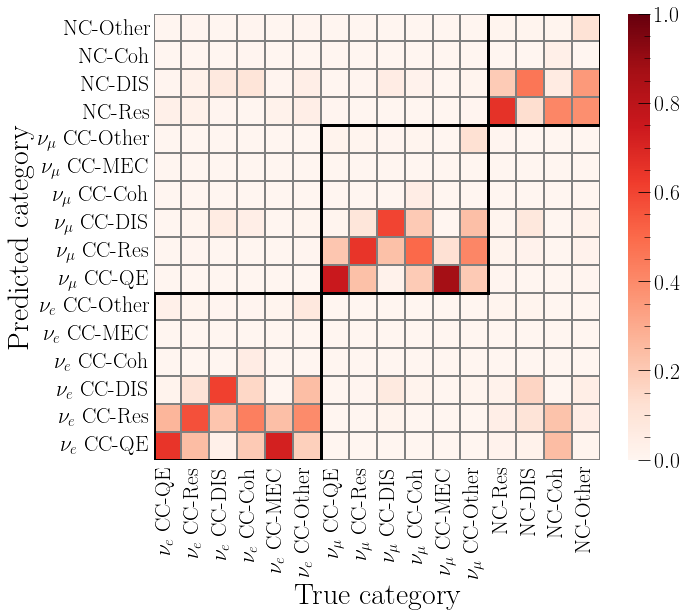

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[1]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_flux_matrix")

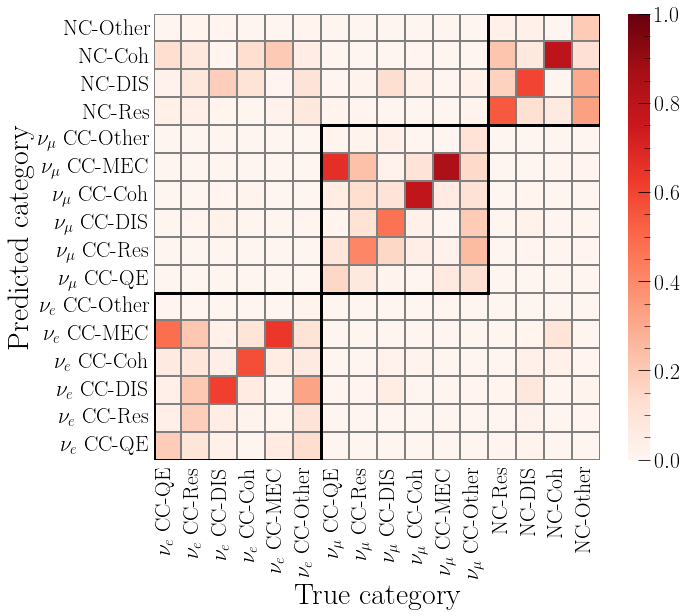

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[2]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_uniform_matrix")

In [15]:
# Tidy up
del outputs

<a id='repr'></a>

## Which image representation is best? (repr)
* The theta/phi representation as viewed from the roughly reconstructed interaction vertex is clearly the best
* It does seem to do this by sacrificing a bit of purity for greater efficiency, but overall its still better.
* The fact that both origin view representations are similar, hints that the parameterisation is less important and where you view the interaction from is key.

In [16]:
v_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Vertex theta/phi repr
o_out = chipsnet.utils.evaluate(config, "o_ct_flux", ["repr_o_ct"], ["t_all_cat"], just_out=True)  # Origin theta/phi repr
i_out = chipsnet.utils.evaluate(config, "i_ct_flux", ["repr_i_ct"], ["t_all_cat"], just_out=True)  # Origin x+/x- repr


************************ Evaluating v_ct_flux ************************
Weights: (17296,0.00225), (17293,0.00015), (101923,0.03290), (17298,0.00424), (0,0.00000)
Cuts:    (112080,0.95057), (94508,0.91796), (23721,0.67508), (0,0.00000)

------------------------ repr_v_ct report ------------------------
- Comb-> Prec: (0.94218,0.71150), Rec: (0.90507,0.84822), F1: (0.91744,0.72794)
- Cat->  Prec: (0.57128,0.34714), Rec: (0.55851,0.33132), F1: (0.54248,0.28258)

- Nuel-> ROC-AUC: 0.82239, PRC-AUC: 0.68252, S-Eff: 0.87097, S-Pur: 0.35022
- FOM1-> 0.43695, 0.93000, 53.90627, 11.65725, 18.24847, 0.67935, 0.64318
- FOM2-> 11.89406, 0.98500, 32.34586, 2.75890, 4.63677, 0.40764, 0.81391

- Numu-> ROC-AUC: 0.66669, PRC-AUC: 0.91924, S-Eff: 0.86807, S-Pur: 0.98860
- FOM1-> 0.86833, 0.16000, 4.35706, 1829.38890, 49.05891, 0.89368, 0.97163
- FOM2-> 1494.11745, 0.99500, 0.06769, 1527.63001, 0.97767, 0.74627, 0.99932

took 329.37 seconds

************************ Evaluating o_ct_flux ****************

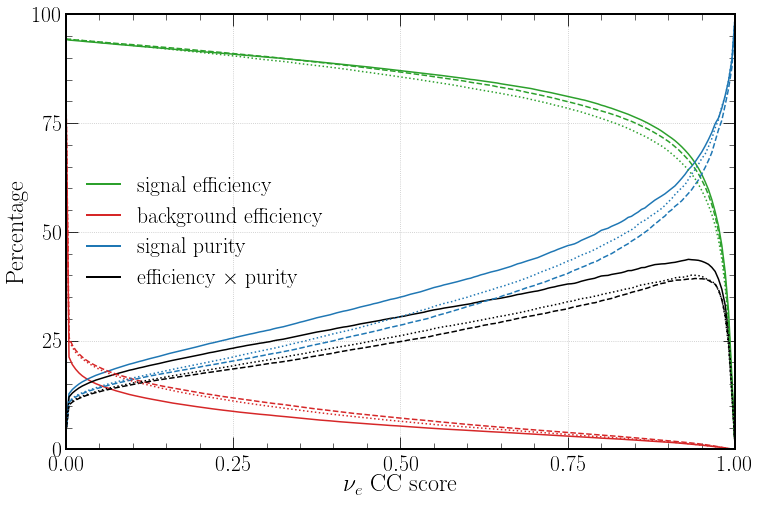

In [17]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_eff_curves")

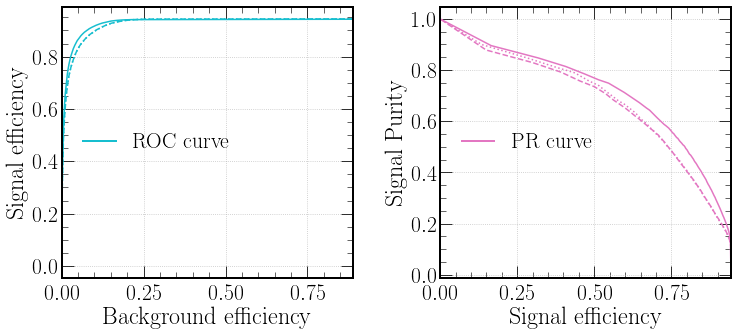

In [18]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_comp_curves")

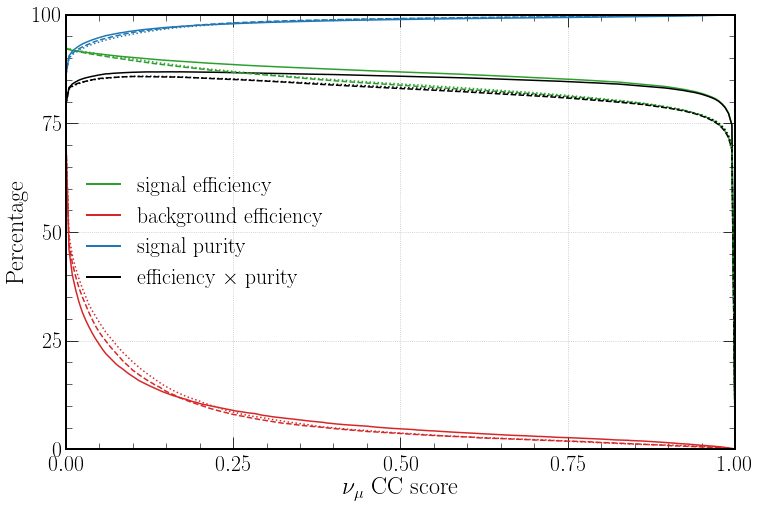

In [19]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_eff_curves")

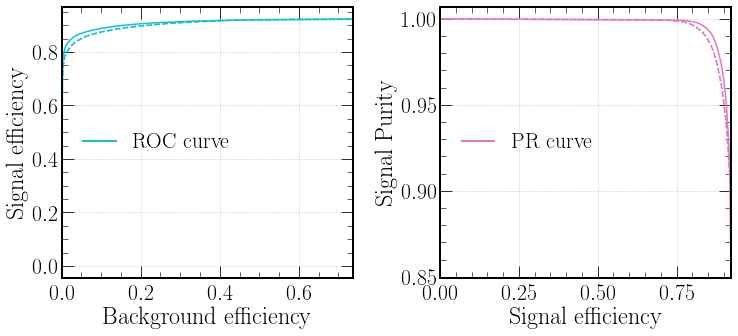

In [20]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_comp_curves")

In [21]:
# Tidy up
del v_out
del o_out
del i_out

<a id='channel'></a>

## Which channel configuration is best? (channel)
* The differences are much smaller than you would expect given the extra info you would think the extra channels provide
* Overall having all three channels together does make a difference
* It also is much better to have the seperate stems for each channel rather than using a single 3 channel image

In [22]:
c_out = chipsnet.utils.evaluate(config, "v_c_flux", ["repr_v_c"], ["t_all_cat"], just_out=True)  # Just charge channel
ct_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Charge+time channels
cth_out = chipsnet.utils.evaluate(config,"v_cth_flux", ["repr_v_cth"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels
cth_stacked_out = chipsnet.utils.evaluate(config, "v_cth_flux_stacked", ["repr_v_cth_stacked"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels stacked


************************ Evaluating v_c_flux ************************
Weights: (17296,0.00225), (17293,0.00015), (101923,0.03290), (17298,0.00424), (0,0.00000)
Cuts:    (112080,0.95057), (94508,0.91796), (23721,0.67508), (0,0.00000)

------------------------ repr_v_c report ------------------------
- Comb-> Prec: (0.93897,0.69945), Rec: (0.89823,0.84397), F1: (0.91232,0.71821)
- Cat->  Prec: (0.55908,0.33964), Rec: (0.54419,0.31875), F1: (0.53003,0.27380)

- Nuel-> ROC-AUC: 0.82043, PRC-AUC: 0.65808, S-Eff: 0.86362, S-Pur: 0.33629
- FOM1-> 0.40961, 0.93500, 51.09496, 12.42008, 16.80811, 0.64392, 0.63612
- FOM2-> 11.00572, 0.98000, 34.55349, 3.90040, 5.95665, 0.43546, 0.77805

- Numu-> ROC-AUC: 0.66457, PRC-AUC: 0.91876, S-Eff: 0.86071, S-Pur: 0.98887
- FOM1-> 0.86233, 0.17500, 4.30447, 1817.17508, 49.20223, 0.88772, 0.97140
- FOM2-> 1443.53919, 0.99500, 0.07469, 1520.84403, 1.03529, 0.74295, 0.99927

took 249.30 seconds

************************ Evaluating v_ct_flux ******************

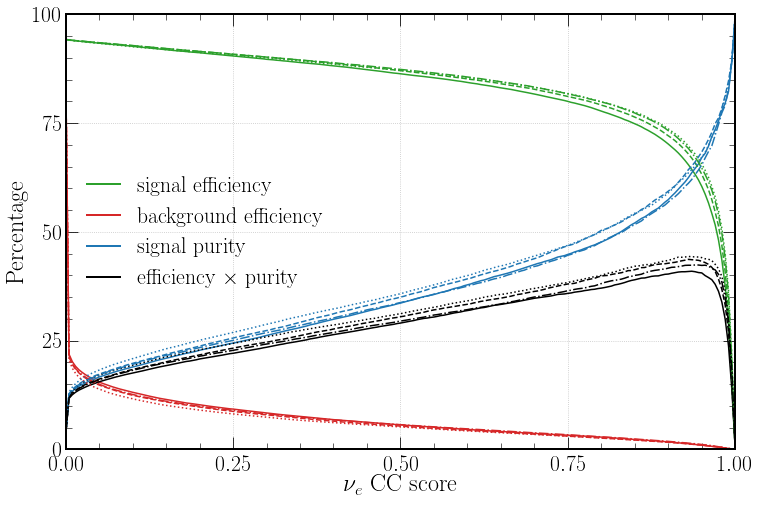

In [23]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_eff_curves")

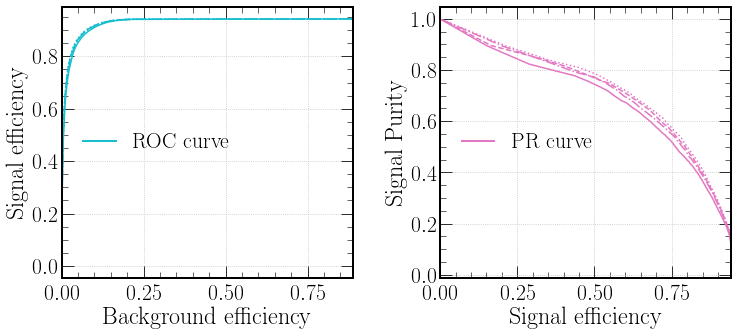

In [24]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_comp_curves")

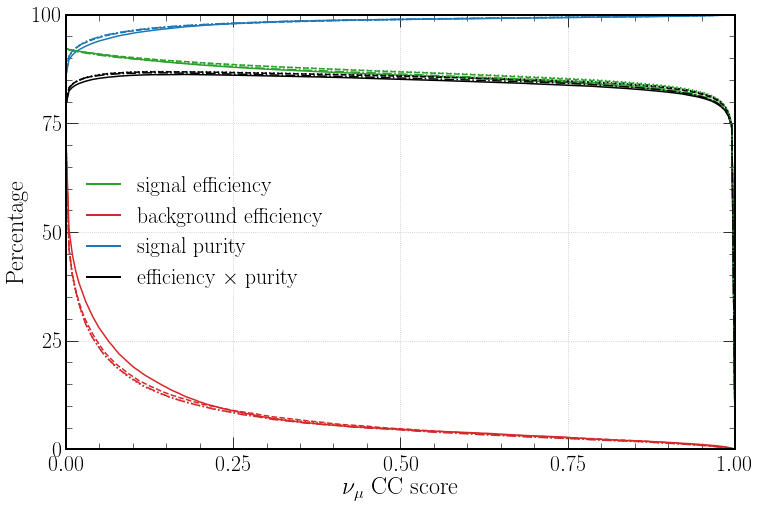

In [25]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_eff_curves")

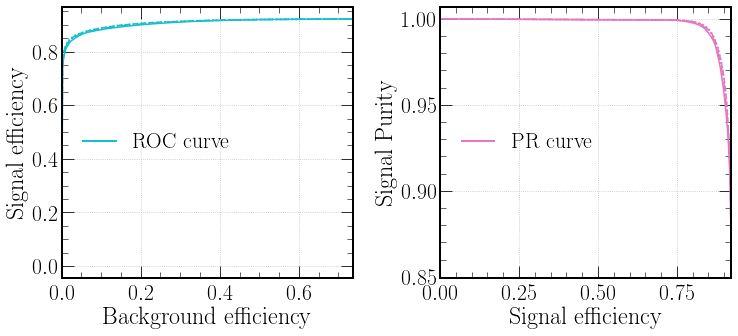

In [26]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_comp_curves")

In [27]:
# Tidy up
del c_out
del ct_out
del cth_out
del cth_stacked_out

<a id='cat'></a>

## Which categorisation is best? (cat)
* It looks like the split learner using ["t_comb_cat", "t_cc_type", "t_nc_type"] is the best
* Still need to look at how well it splits apart to cc and nc types for full analysis
* A close second is then "t_nu_nc_cat" maybe this is still reasonable to use to simplify other studies

In [ ]:
events, outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["cat_t_final_cat", "cat_t_all_cat", "cat_t_comb_cat", "cat_t_nu_nc_cat", "cat_t_nc_cat", "cat_split", "cat_split_learn"], 
    ["t_final_cat", "t_all_cat", "t_comb_cat", "t_nu_nc_cat", "t_nc_cat", "t_comb_cat", "t_comb_cat"],
    just_out=True
)

In [ ]:
chipsnet.plotting.plot_eff_curves([outputs[3], outputs[0], outputs[1], outputs[5]], 0, save_path+"cat_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([outputs[3], outputs[0], outputs[1], outputs[5]], 0, save_path+"cat_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([outputs[3], outputs[0], outputs[1], outputs[5]], 1, save_path+"cat_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([outputs[3], outputs[0], outputs[1], outputs[5]], 1, save_path+"cat_numu_comp_curves")

In [ ]:
# Tidy up
del outputs

<a id='cosmic'></a>

## Does vertex help cosmic classifier? (cosmic)
* Can't really come to a full conclusion without knowing if the events that pass will contaminate our signal
* Looks like adding the vertex position and time, makes the average values better, by the number of events that get accepted gets worse.

In [ ]:
chipsnet.utils.evaluate(config, "flux_cosmic", ["cosmic"], ["t_cosmic_cat"])
chipsnet.utils.evaluate(config, "flux_cosmic", ["cosmic_vtx"], ["t_cosmic_cat"])
chipsnet.utils.evaluate(config, "flux_cosmic", ["cosmic_vtx_learn"], ["t_cosmic_cat"])

<a id='beam'></a>

## Does primary count help beam classifier? (beam)
* Yes it does help, not a huge effect but it definitely add something, which makes sense
* The "learned" version of the multitask weights seems to work best.
* Still need to combine with the correct category type to see if that has a different effect.

In [ ]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["beam", "beam_primaries", "beam_primaries_learn"],
    ["t_nu_nc_cat", "t_nu_nc_cat", "t_nu_nc_cat"],
    just_out=True
)

In [ ]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_comp_curves")

In [ ]:
# Tidy up
del outputs

<a id='energy'></a>

## Does lepton energy help neutrino energy estimation? (energy)
* There doesn't seem to be a noticable difference when both are trained together
* This has only been testing on nuel cc, it may be different for numu cc
* As its negligable we will train together using the learned approach as that seems best

In [ ]:
events, outputs = chipsnet.utils.evaluate(
    config,
    "flux",
    ["energy_nu", "energy_lep", "energy_nu_lep", "energy_nu_lep_learn", "energy_nu_lep_vtx", "energy_nu_lep_vtx_learn"],
    ["energy", "energy", "energy", "energy", "energy", "energy"]
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.2})
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_frac_nu_energy")
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:blue")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_lep_frac_nu_energy")
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:orange")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_lep_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:purple")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_lep_vtx_frac_nu_energy")
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:pink")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_lep_vtx_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:red")
axs[0].label_outer()
axs[0].set(ylabel=r"(True-reco)/true $E_{\nu}$", xlabel=r"$\nu$ energy (MeV)")
axs[0].set_ylim(0.0, 0.4)
axs[0].grid()
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="single")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="multi1")
multi_learn = Line2D([0], [0], color="tab:purple", linewidth=2, linestyle="solid", label="multi2")
multi_vtx = Line2D([0], [0], color="tab:pink", linewidth=2, linestyle="solid", label="multi3")
multi_vtx_learn = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label="multi4")
axs[0].legend(handles=[single, multi, multi_learn, multi_vtx, multi_vtx_learn], loc="upper left")

e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 1) & (events["t_lep_energy"] != 0.0)], fit_name="energy_lep_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:blue")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 0) & (events["t_lep_energy"] != 0.0)], fit_name="energy_nu_lep_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:orange")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 0) & (events["t_lep_energy"] != 0.0)], fit_name="energy_nu_lep_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:purple")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 0) & (events["t_lep_energy"] != 0.0)], fit_name="energy_nu_lep_vtx_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:pink")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 0) & (events["t_lep_energy"] != 0.0)], fit_name="energy_nu_lep_vtx_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:red")
axs[1].label_outer()
axs[1].set(ylabel=r"(True-reco)/true $E_{lepton}$", xlabel=r"lepton energy (MeV)")
axs[1].set_ylim(0.0, 0.4)
axs[1].grid()
chipsnet.plotting.save(save_path + "energy_frac_vs_e")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.2})
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_frac_nu_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:blue")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_lep_frac_nu_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:orange")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_lep_learn_frac_nu_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:purple")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_lep_vtx_frac_nu_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:pink")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[events["t_all_cat"] == 0], fit_name="energy_nu_lep_vtx_learn_frac_nu_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[0].errorbar(e_list, std_list, yerr=err_list, color="tab:red")
axs[0].label_outer()
axs[0].set(ylabel=r"(True-reco)/true $E_{\nu}$", xlabel=r"Vertex x-position (cm)")
axs[0].set_ylim(0.0, 0.4)
axs[0].grid()
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="single")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="multi1")
multi_learn = Line2D([0], [0], color="tab:purple", linewidth=2, linestyle="solid", label="multi2")
multi_vtx = Line2D([0], [0], color="tab:pink", linewidth=2, linestyle="solid", label="multi3")
multi_vtx_learn = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label="multi4")
axs[0].legend(handles=[single, multi, multi_learn, multi_vtx, multi_vtx_learn], loc="upper left")

e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 1) & (events["t_lep_energy"] != 0.0)], fit_name="energy_lep_frac_lep_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:blue")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 0) & (events["t_lep_energy"] != 0.0)], fit_name="energy_nu_lep_frac_lep_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:orange")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 0) & (events["t_lep_energy"] != 0.0)], fit_name="energy_nu_lep_learn_frac_lep_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:purple")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 0) & (events["t_lep_energy"] != 0.0)], fit_name="energy_nu_lep_vtx_frac_lep_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:pink")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(events[(events["t_all_cat"] == 0) & (events["t_lep_energy"] != 0.0)], fit_name="energy_nu_lep_vtx_learn_frac_lep_energy",
                                                          par="t_vtx_x", low=-1250, high=1250, bin_size=200)
axs[1].errorbar(e_list, std_list, yerr=err_list, color="tab:red")
axs[1].label_outer()
axs[1].set(ylabel=r"(True-reco)/true $E_{lepton}$", xlabel=r"Vertex x-position (cm)")
axs[1].set_ylim(0.0, 0.4)
axs[1].grid()
chipsnet.plotting.save(save_path + "energy_frac_vs_vtx")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(
    events[events["t_comb_cat"] == 0]['energy_nu_frac_nu_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"], 
    range=(-0.4, 0.5), bins=35, histtype='step', color="tab:blue"
)
axs[0].hist(
    events[events["t_comb_cat"] == 0]['energy_nu_lep_frac_nu_energy'],
    weights=events[events["t_comb_cat"] == 0]["w"], 
    range=(-0.4, 0.5), bins=35, histtype='step', color="tab:orange"
)
axs[0].hist(
    events[events["t_comb_cat"] == 0]['energy_nu_lep_learn_frac_nu_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.4, 0.5), bins=35, histtype='step', color="tab:purple"
)
axs[0].hist(
    events[events["t_comb_cat"] == 0]['energy_nu_lep_vtx_frac_nu_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.4, 0.5), bins=35, histtype='step', color="tab:pink"
)
axs[0].hist(
    events[events["t_comb_cat"] == 0]['energy_nu_lep_vtx_learn_frac_nu_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.4, 0.5), bins=35, histtype='step', color="tab:red"
)
axs[0].set(xlabel=r"(True-reco)/true $\nu$ E", ylabel=r"Events (arb.)")
axs[0].grid()
axs[0].label_outer()
axs[0].set_ylim(0, 5.0)
axs[1].hist(
    events[events["t_comb_cat"] == 0]['energy_lep_frac_lep_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.4, 0.4), bins=30, histtype='step', color="tab:blue"
)
axs[1].hist(
    events[events["t_comb_cat"] == 0]['energy_nu_lep_frac_lep_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.4, 0.4), bins=30, histtype='step', color="tab:orange"
)
axs[1].hist(
    events[events["t_comb_cat"] == 0]['energy_nu_lep_learn_frac_lep_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.4, 0.4), bins=30, histtype='step', color="tab:purple"
)
axs[1].hist(
    events[events["t_comb_cat"] == 0]['energy_nu_lep_vtx_frac_lep_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.4, 0.4), bins=30, histtype='step', color="tab:pink"
)
axs[1].hist(
    events[events["t_comb_cat"] == 0]['energy_nu_lep_vtx_learn_frac_lep_energy'], 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-0.4, 0.4), bins=30, histtype='step', color="tab:red"
)
axs[1].set(xlabel=r"(True-reco)/true lepton E", ylabel=r"Events / $6\times10^{20}$ POT / kt")
axs[1].grid()
axs[1].label_outer()
axs[1].set_ylim(0, 5.0)
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="single")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="multi1")
multi_learn = Line2D([0], [0], color="tab:purple", linewidth=2, linestyle="solid", label="multi2")
multi_vtx = Line2D([0], [0], color="tab:pink", linewidth=2, linestyle="solid", label="multi3")
multi_vtx_learn = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label="multi3")
axs[1].legend(handles=[single, multi, multi_learn, multi_vtx, multi_vtx_learn], loc="upper right")
chipsnet.plotting.save(save_path + "energy_frac_dist")

In [ ]:
print(events[events["t_comb_cat"] == 0]['energy_nu_frac_nu_energy'].describe())
print(events[events["t_comb_cat"] == 0]['energy_nu_lep_frac_nu_energy'].describe())
print(events[events["t_comb_cat"] == 0]['energy_nu_lep_learn_frac_nu_energy'].describe())
print(events[events["t_comb_cat"] == 0]['energy_nu_lep_vtx_frac_nu_energy'].describe())
print(events[events["t_comb_cat"] == 0]['energy_nu_lep_vtx_learn_frac_nu_energy'].describe())

In [ ]:
print(events[(events["t_comb_cat"] == 0) & (events["t_lep_energy"] != 0.0)]['energy_lep_frac_lep_energy'].describe())
print(events[(events["t_comb_cat"] == 0) & (events["t_lep_energy"] != 0.0)]['energy_nu_lep_frac_lep_energy'].describe())
print(events[(events["t_comb_cat"] == 0) & (events["t_lep_energy"] != 0.0)]['energy_nu_lep_learn_frac_lep_energy'].describe())
print(events[(events["t_comb_cat"] == 0) & (events["t_lep_energy"] != 0.0)]['energy_nu_lep_vtx_frac_lep_energy'].describe())
print(events[(events["t_comb_cat"] == 0) & (events["t_lep_energy"] != 0.0)]['energy_nu_lep_vtx_learn_frac_lep_energy'].describe())

In [ ]:
# Tidy up
del events, outputs

<a id='energy_samples'></a>

## Different sample energy estimation (energy_samples)
* The vertex location for muon events greatly effects the energy reconstruction performance due to not being fully contained.
* Can reach 5% energy resolution of QEL and MEC electrons.
* Lots of the DIS/RES are not having their true lepton energy found which is odd.

In [ ]:
# All the different interaction type samples and associated models
nuel_cccoh_ev, outs = chipsnet.utils.evaluate(config, "nuel_cccoh", ["final_nuel_cccoh_e"], ["energy"])
nuel_ccdis_ev, outs = chipsnet.utils.evaluate(config, "nuel_ccdis", ["final_nuel_ccdis_e"], ["energy"])
nuel_ccqel_ev, outs = chipsnet.utils.evaluate(config, "nuel_ccqel", ["final_nuel_ccqel_e"], ["energy"])
nuel_ccres_ev, outs = chipsnet.utils.evaluate(config, "nuel_ccres", ["final_nuel_ccres_e"], ["energy"])
numu_cccoh_ev, outs = chipsnet.utils.evaluate(config, "numu_cccoh", ["final_numu_cccoh_e"], ["energy"])
numu_ccdis_ev, outs = chipsnet.utils.evaluate(config, "numu_ccdis", ["final_numu_ccdis_e"], ["energy"])
numu_ccqel_ev, outs = chipsnet.utils.evaluate(config, "numu_ccqel", ["final_numu_ccqel_e"], ["energy"])
numu_ccres_ev, outs = chipsnet.utils.evaluate(config, "numu_ccres", ["final_numu_ccres_e"], ["energy"])
flux_ev, outs = chipsnet.utils.evaluate(config, "flux", ["final_nuel_cc_e", "final_numu_cc_e", "final_nc_e"], ["energy", "energy", "energy"])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['t_nu_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:blue")
axs[0].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['final_nuel_cc_e_pred_t_nu_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:orange")
axs[0].set(xlabel=r"$\nu$ energy (MeV)", ylabel=r"Events / $6\times10^{20}$ POT / kt / 250 MeV")
axs[0].label_outer()
axs[0].set_ylim(0, 2.5)
axs[1].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['t_lep_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:blue")
axs[1].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['final_nuel_cc_e_pred_t_lep_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:orange")
axs[1].set(xlabel=r"lepton energy (MeV)")
axs[1].label_outer()
axs[1].set_ylim(0, 2.5)
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="true")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="reco")
axs[1].legend(handles=[single, multi], loc="upper right")
chipsnet.plotting.save(save_path + "energy_samples_dists")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(flux_ev[(flux_ev["t_comb_cat"] == 1) & (flux_ev["t_lep_energy"] != 0.0)]['t_nu_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 1) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:green")
axs[0].hist(flux_ev[(flux_ev["t_comb_cat"] == 1) & (flux_ev["t_lep_energy"] != 0.0)]['final_numu_cc_e_pred_t_nu_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 1) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:red")
axs[0].set(xlabel=r"$\nu_{\mu}$ energy (MeV)", ylabel=r"Events / $6\times10^{20}$ POT / kt / 250 MeV")
axs[0].label_outer()
axs[0].set_ylim(0, 600)
axs[1].hist(flux_ev[(flux_ev["t_comb_cat"] == 1) & (flux_ev["t_lep_energy"] != 0.0)]['t_lep_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 1) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:green")
axs[1].hist(flux_ev[(flux_ev["t_comb_cat"] == 1) & (flux_ev["t_lep_energy"] != 0.0)]['final_numu_cc_e_pred_t_lep_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 1) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:red")
axs[1].set(xlabel=r"$\mu$ energy (MeV)")
axs[1].label_outer()
axs[1].set_ylim(0, 600)
single = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label="true")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label="reco")
axs[1].legend(handles=[single, multi], loc="upper right")
chipsnet.plotting.save(save_path + "energy_samples_dists")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(nuel_ccdis_ev[nuel_ccdis_ev["t_lep_energy"] != 0.0]['t_nu_energy'], 
            weights=nuel_ccdis_ev[nuel_ccdis_ev["t_lep_energy"] != 0.0]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:blue")
axs[0].hist(nuel_ccdis_ev[nuel_ccdis_ev["t_lep_energy"] != 0.0]['final_nuel_ccdis_e_pred_t_nu_energy'], 
            weights=nuel_ccdis_ev[nuel_ccdis_ev["t_lep_energy"] != 0.0]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:orange")
axs[0].set(xlabel=r"$\nu_{\mu}$ energy (MeV)", ylabel=r"Events / $6\times10^{20}$ POT / kt / 250 MeV")
axs[0].label_outer()
#axs[0].set_ylim(0, 600)
axs[1].hist(nuel_ccdis_ev[nuel_ccdis_ev["t_lep_energy"] != 0.0]['t_lep_energy'], 
            weights=nuel_ccdis_ev[nuel_ccdis_ev["t_lep_energy"] != 0.0]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:blue")
axs[1].hist(nuel_ccdis_ev[nuel_ccdis_ev["t_lep_energy"] != 0.0]['final_nuel_ccdis_e_pred_t_lep_energy'], 
            weights=nuel_ccdis_ev[nuel_ccdis_ev["t_lep_energy"] != 0.0]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:orange")
axs[1].set(xlabel=r"$\mu$ energy (MeV)")
axs[1].label_outer()
#axs[1].set_ylim(0, 600)
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="true")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="reco")
axs[1].legend(handles=[single, multi], loc="upper right")
chipsnet.plotting.save(save_path + "energy_samples_dists")

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(4, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
axs[0, 0].hist2d(nuel_cccoh_ev["t_nu_energy"], nuel_cccoh_ev["final_nuel_cccoh_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 0].grid()
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"Reco energy (MeV)")
axs[0, 0].set_title(r"nuel")
axs[1, 0].hist2d(nuel_ccdis_ev["t_nu_energy"], nuel_ccdis_ev["final_nuel_ccdis_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 0].grid()
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"Reco energy (MeV)")
axs[2, 0].hist2d(nuel_ccqel_ev["t_nu_energy"], nuel_ccqel_ev["final_nuel_ccqel_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 0].grid()
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"Reco energy (MeV)")
axs[3, 0].hist2d(nuel_ccres_ev["t_nu_energy"], nuel_ccres_ev["final_nuel_ccres_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 0].grid()
axs[3, 0].label_outer()
axs[3, 0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0, 1].hist2d(numu_cccoh_ev["t_nu_energy"], numu_cccoh_ev["final_numu_cccoh_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 1].grid()
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(8000, 2250, "CC-COH", rotation=-90)
axs[1, 1].hist2d(numu_ccdis_ev["t_nu_energy"], numu_ccdis_ev["final_numu_ccdis_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 1].grid()
axs[1, 1].label_outer()
axs[1, 1].text(8000, 2250, "CC-DIS", rotation=-90)
axs[2, 1].hist2d(numu_ccqel_ev["t_nu_energy"], numu_ccqel_ev["final_numu_ccqel_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 1].grid()
axs[2, 1].label_outer()
axs[2, 1].text(8000, 2250, "CC-QEL", rotation=-90)
axs[3, 1].hist2d(numu_ccres_ev["t_nu_energy"], numu_ccres_ev["final_numu_ccres_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 1].grid()
axs[3, 1].label_outer()
axs[3, 1].text(8000, 2250, "CC-RES", rotation=-90)
axs[3, 1].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_cc")

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
axs[0].hist2d(flux_ev[flux_ev["t_comb_cat"] == 0]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 0]["final_nuel_cc_e_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[0].grid()
axs[0].label_outer()
axs[0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0].set_title(r"Nuel CC")
axs[1].hist2d(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 1]["final_numu_cc_e_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"], cmap="Reds")
axs[1].grid()
axs[1].label_outer()
axs[1].set(xlabel=r"True energy (MeV)")
axs[1].set_title(r"Numu CC")
axs[2].hist2d(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 2]["final_nc_e_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"], cmap="Reds")
axs[2].grid()
axs[2].label_outer()
axs[2].set(xlabel=r"True energy (MeV)")
axs[2].set_title(r"NC")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_comb")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, fit_name="final_nuel_cccoh_e_frac_lep_energy", par="t_lep_energy")
axs[0, 0].errorbar(e_list, std_list, yerr=err_list, color="tab:blue")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(flux_ev[flux_ev["t_all_cat"] == 3], fit_name="final_nuel_cc_e_frac_lep_energy", par="t_lep_energy")
axs[0, 0].errorbar(e_list, std_list, yerr=err_list, color="tab:red")
axs[0, 0].set_ylim(0, 0.5)
axs[0, 1].hist(
    nuel_cccoh_ev[nuel_cccoh_ev["t_lep_energy"] != 0.0]['final_nuel_cccoh_e_frac_lep_energy'], 
    range=(-0.4, 0.4), bins=30, histtype='step', color="tab:blue", density=True
)
axs[0, 1].hist(
    flux_ev[(flux_ev["t_all_cat"] == 3) & (flux_ev["t_lep_energy"] != 0.0)]['final_nuel_cc_e_frac_lep_energy'], 
    range=(-0.4, 0.4), bins=30, histtype='step', color="tab:red", density=True
)
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, fit_name="final_nuel_cccoh_e_frac_nu_energy", par="t_nu_energy")
axs[1, 0].errorbar(e_list, std_list, yerr=err_list, color="tab:blue")
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(flux_ev[flux_ev["t_all_cat"] == 3], fit_name="final_nuel_cc_e_frac_nu_energy", par="t_nu_energy")
axs[1, 0].errorbar(e_list, std_list, yerr=err_list, color="tab:red")
axs[1, 0].set_ylim(0, 0.5)
axs[1, 1].hist(
    nuel_cccoh_ev[nuel_cccoh_ev["t_lep_energy"] != 0.0]['final_nuel_cccoh_e_frac_nu_energy'], 
    range=(-0.4, 0.4), bins=30, histtype='step', color="tab:blue", density=True
)
axs[1, 1].hist(
    flux_ev[(flux_ev["t_all_cat"] == 3) & (flux_ev["t_lep_energy"] != 0.0)]['final_nuel_cc_e_frac_nu_energy'], 
    range=(-0.4, 0.4), bins=30, histtype='step', color="tab:red", density=True
)
plt.show()

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
e_list, std_list, err_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, fit_name="final_nuel_cccoh_e_frac_nu_energy", par="t_nu_energy")
axs[0, 0].errorbar(e_list, std_list, yerr=err_list, color="tab:blue")


e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, fit_name="nuel_cccoh_energy_frac_nu_energy")
axs[0, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, par="t_lep_energy", fit_name="nuel_cccoh_energy_frac_lep_energy")
axs[0, 0].plot(e_list, std_list)
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"(True-reco)/true E")
axs[0, 0].set_title(r"nuel")
axs[0, 0].set_ylim(0, 0.5)
axs[0, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev, fit_name="nuel_ccdis_energy_frac_nu_energy")
axs[1, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev, par="t_lep_energy", fit_name="nuel_ccdis_energy_frac_lep_energy")
axs[1, 0].plot(e_list, std_list)
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"(True-reco)/true E")
axs[1, 0].set_ylim(0, 0.5)
axs[1, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev, fit_name="nuel_ccqel_energy_frac_nu_energy")
axs[2, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev, par="t_lep_energy", fit_name="nuel_ccqel_energy_frac_lep_energy")
axs[2, 0].plot(e_list, std_list)
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"(True-reco)/true E")
axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev, fit_name="nuel_ccres_energy_frac_nu_energy")
axs[3, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev, par="t_lep_energy", fit_name="nuel_ccres_energy_frac_lep_energy")
axs[3, 0].plot(e_list, std_list)
axs[3, 0].label_outer()
axs[3, 0].set(ylabel=r"(True-reco)/true E")
axs[3, 0].set_ylim(0, 0.5)
axs[3, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev, fit_name="nuel_ccmec_energy_frac_nu_energy")
axs[4, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev, par="t_lep_energy", fit_name="nuel_ccmec_energy_frac_lep_energy")
axs[4, 0].plot(e_list, std_list)
axs[4, 0].label_outer()
axs[4, 0].set(ylabel=r"(True-reco)/true E")
axs[4, 0].set_ylim(0, 0.5)
axs[4, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqelmec_ev, fit_name="nuel_ccqelmec_energy_frac_nu_energy")
axs[5, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqelmec_ev, par="t_lep_energy", fit_name="nuel_ccqelmec_energy_frac_lep_energy")
axs[5, 0].plot(e_list, std_list)
axs[5, 0].label_outer()
axs[5, 0].set(xlabel=r"Neutrino energy (MeV)", ylabel=r"(True-reco)/true E")
axs[5, 0].set_ylim(0, 0.5)
axs[5, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev, fit_name="numu_cccoh_energy_frac_nu_energy")
axs[0, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev, par="t_lep_energy", fit_name="numu_cccoh_energy_frac_lep_energy")
axs[0, 1].plot(e_list, std_list)
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(8000, 0.15, "CC-COH", rotation=-90)
axs[0, 1].set_ylim(0, 0.5)
axs[0, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev, fit_name="numu_ccdis_energy_frac_nu_energy")
axs[1, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev, par="t_lep_energy", fit_name="numu_ccdis_energy_frac_lep_energy")
axs[1, 1].plot(e_list, std_list)
axs[1, 1].label_outer()
axs[1, 1].text(8000, 0.15, "CC-DIS", rotation=-90)
axs[1, 1].set_ylim(0, 0.5)
axs[1, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev, fit_name="numu_ccqel_energy_frac_nu_energy")
axs[2, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev, par="t_lep_energy", fit_name="numu_ccqel_energy_frac_lep_energy")
axs[2, 1].plot(e_list, std_list)
axs[2, 1].label_outer()
axs[2, 1].text(8000, 0.15, "CC-QEL", rotation=-90)
axs[2, 1].set_ylim(0, 0.5)
axs[2, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev, fit_name="numu_ccres_energy_frac_nu_energy")
axs[3, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev, par="t_lep_energy", fit_name="numu_ccres_energy_frac_lep_energy")
axs[3, 1].plot(e_list, std_list)
axs[3, 1].label_outer()
axs[3, 1].text(8000, 0.15, "CC-RES", rotation=-90)
axs[3, 1].set_ylim(0, 0.5)
axs[3, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev, fit_name="numu_ccmec_energy_frac_nu_energy")
axs[4, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev, par="t_lep_energy", fit_name="numu_ccmec_energy_frac_lep_energy")
axs[4, 1].plot(e_list, std_list)
axs[4, 1].label_outer()
axs[4, 1].text(8000, 0.15, "CC-MEC", rotation=-90)
axs[4, 1].set_ylim(0, 0.5)
axs[4, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqelmec_ev, fit_name="numu_ccqelmec_energy_frac_nu_energy")
axs[5, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqelmec_ev, par="t_lep_energy", fit_name="numu_ccqelmec_energy_frac_lep_energy")
axs[5, 1].plot(e_list, std_list)
axs[5, 1].label_outer()
axs[5, 1].set(xlabel=r"Neutrino energy (MeV)")
axs[5, 1].text(8000, 0.05, "CC-QELMEC", rotation=-90)
axs[5, 1].set_ylim(0, 0.5)
axs[5, 1].grid()
chipsnet.plotting.save(save_path + "true_vs_frac_energy")

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_cccoh_energy_frac_nu_energy")
axs[0, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_cccoh_ev[(nuel_cccoh_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_cccoh_energy_frac_lep_energy")
axs[0, 0].plot(e_list, std_list)
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"(True-reco)/true E")
axs[0, 0].set_title(r"nuel")
axs[0, 0].set_ylim(0, 0.5)
axs[0, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccdis_energy_frac_nu_energy")
axs[1, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccdis_ev[(nuel_ccdis_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccdis_energy_frac_lep_energy")
axs[1, 0].plot(e_list, std_list)
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"(True-reco)/true E")
axs[1, 0].set_ylim(0, 0.5)
axs[1, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccqel_energy_frac_nu_energy")
axs[2, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccqel_ev[(nuel_ccqel_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccqel_energy_frac_lep_energy")
axs[2, 0].plot(e_list, std_list)
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"(True-reco)/true E")
axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccres_energy_frac_nu_energy")
axs[3, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccres_ev[(nuel_ccres_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccres_energy_frac_lep_energy")
axs[3, 0].plot(e_list, std_list)
axs[3, 0].label_outer()
axs[3, 0].set(ylabel=r"(True-reco)/true E")
axs[3, 0].set_ylim(0, 0.5)
axs[3, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccmec_energy_frac_nu_energy")
axs[4, 0].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(nuel_ccmec_ev[(nuel_ccmec_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="nuel_ccmec_energy_frac_lep_energy")
axs[4, 0].plot(e_list, std_list)
axs[4, 0].label_outer()
axs[4, 0].set(xlabel=r"Vertex x-position (cm)", ylabel=r"(True-reco)/true E")
axs[4, 0].set_ylim(0, 0.5)
axs[4, 0].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_cccoh_energy_frac_nu_energy")
axs[0, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_cccoh_ev[(numu_cccoh_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_cccoh_energy_frac_lep_energy")
axs[0, 1].plot(e_list, std_list)
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(1200, 0.15, "CC-COH", rotation=-90)
axs[0, 1].set_ylim(0, 0.5)
axs[0, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccdis_energy_frac_nu_energy")
axs[1, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccdis_ev[(numu_ccdis_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccdis_energy_frac_lep_energy")
axs[1, 1].plot(e_list, std_list)
axs[1, 1].label_outer()
axs[1, 1].text(1200, 0.15, "CC-DIS", rotation=-90)
axs[1, 1].set_ylim(0, 0.5)
axs[1, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccqel_energy_frac_nu_energy")
axs[2, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccqel_ev[(numu_ccqel_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccqel_energy_frac_lep_energy")
axs[2, 1].plot(e_list, std_list)
axs[2, 1].label_outer()
axs[2, 1].text(1200, 0.15, "CC-QEL", rotation=-90)
axs[2, 1].set_ylim(0, 0.5)
axs[2, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccres_energy_frac_nu_energy")
axs[3, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccres_ev[(numu_ccres_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccres_energy_frac_lep_energy")
axs[3, 1].plot(e_list, std_list)
axs[3, 1].label_outer()
axs[3, 1].text(1200, 0.15, "CC-RES", rotation=-90)
axs[3, 1].set_ylim(0, 0.5)
axs[3, 1].grid()
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev, par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccmec_energy_frac_nu_energy")
axs[4, 1].plot(e_list, std_list)
e_list, std_list = chipsnet.utils.frac_e_vs_par(numu_ccmec_ev[(numu_ccmec_ev["t_lep_energy"] > 0.0)], par="t_vtx_x", low=-1250, high=1250, bin_size=100, fit_name="numu_ccmec_energy_frac_lep_energy")
axs[4, 1].plot(e_list, std_list)
axs[4, 1].label_outer()
axs[4, 1].set(xlabel=r"Vertex x-position (cm)")
axs[4, 1].text(1200, 0.15, "CC-MEC", rotation=-90)
axs[4, 1].set_ylim(0, 0.5)
axs[4, 1].grid()
chipsnet.plotting.save(save_path + "vtx_vs_frac_energy")

<a id='final'></a>

## Final performance and comparison with old reco/pid (final)
* 1
* 2
* 3

In [ ]:
events, outputs = chipsnet.utils.evaluate(
    config, "flux_cosmic", 
    ["final_cosmic", "final_beam", "final_nuel_cc_e", "final_numu_cc_e", "final_nc_e",
     "final_nuel_cccoh_e", "final_nuel_ccdis_e", "final_nuel_ccqel_e", "final_nuel_ccres_e",
     "final_numu_cccoh_e", "final_numu_ccdis_e", "final_numu_ccqel_e", "final_numu_ccres_e"],
    ["t_cosmic_cat", "t_comb_cat", "energy", "energy", "energy",
     "energy", "energy", "energy", "energy",
     "energy", "energy", "energy", "energy"]
)

In [ ]:
# Get events run through old reco/pid for comparisons
old_events = pd.concat([
    chipsnet.utils.get_old_df(old_nuel_file, 11),
    chipsnet.utils.get_old_df(old_numu_file, 13)
])

In [ ]:
chipsnet.plotting.plot_combined_values(events, "final_beam_", save_path+"final_beam_outputs")

In [ ]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 0, save_path+"final_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 0, save_path+"final_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 1, save_path+"final_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 1, save_path+"final_numu_comp_curves")

In [ ]:
chipsnet.plotting.plot_nuel_hists([outputs[0]], events, save_path+"final_nuel_hists")

In [ ]:
chipsnet.plotting.plot_numu_hists([outputs[0]], events, save_path+"final_numu_hists")

In [ ]:
chipsnet.plotting.plot_history(config, "final_cosmic", save_path+"final_cosmic_history", key="accuracy")

In [ ]:
chipsnet.plotting.plot_history(config, "final_beam", save_path+"final_beam_history", key="t_comb_cat_accuracy")

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    outputs[0]["comb_matrix"],
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"],
    yticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_comb_cat_confusion")

In [ ]:
events["final_beam_t_cc_type_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_cc_type")["categories"], "final_beam_pred_t_cc_type_"),
)
cc_matrix = confusion_matrix(
    events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] != 2)]["t_cc_type"],
    events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] != 2)]["final_beam_t_cc_type_class"],
    labels=[x for x in range(6)],
    sample_weight=events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] != 2)]["w"],
    normalize="true",
)
cc_matrix = np.rot90(cc_matrix, 1)
cc_matrix = pd.DataFrame(cc_matrix)
cc_matrix = cc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    cc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_CC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_CC_CAT["labels"][:5][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_cc_type_confusion")

In [ ]:
events["final_beam_t_nc_type_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_nc_type")["categories"], "final_beam_pred_t_nc_type_"),
)
nc_matrix = confusion_matrix(
    events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] == 2)]["t_nc_type"],
    events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] == 2)]["final_beam_t_nc_type_class"],
    labels=[x for x in range(6)],
    sample_weight=events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] == 2)]["w"],
    normalize="true",
)
nc_matrix = np.rot90(nc_matrix, 1)
nc_matrix = pd.DataFrame(nc_matrix)
nc_matrix = nc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    nc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_NC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_NC_CAT["labels"][:5][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_nc_type_confusion")

In [ ]:
out_80 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.8) & (events["frac_energy"] < 1.0)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_60 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.6) & (events["frac_energy"] < 0.8)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_40 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.4) & (events["frac_energy"] < 0.6)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_20 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.2) & (events["frac_energy"] < 0.4)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(1.25, 8.25, 0.5)
axs.errorbar(
    bins,
    out_80["fom_effs"][0][0][0],
    yerr=out_80["fom_effs"][0][0][1],
    color="tab:green"
)
axs.errorbar(
    bins,
    out_60["fom_effs"][0][0][0],
    yerr=out_60["fom_effs"][0][0][1],
    color="tab:blue"
)
axs.errorbar(
    bins,
    out_40["fom_effs"][0][0][0],
    yerr=out_40["fom_effs"][0][0][1],
    color="tab:red"
)
axs.errorbar(
    bins,
    out_20["fom_effs"][0][0][0],
    yerr=out_20["fom_effs"][0][0][1],
    color="tab:pink"
)
axs.set_xlabel("Neutrino energy (GeV)", fontsize=24)
axs.set_ylabel("Efficiency", fontsize=24)
axs.set_ylim([0, 1])
leg_80 = Line2D([0], [0], color="tab:green", linewidth=2, label=r"80\% - 100\%")
leg_60 = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"60\% - 80\%")
leg_40 = Line2D([0], [0], color="tab:red", linewidth=2, label=r"40\% - 60\%")
leg_20 = Line2D([0], [0], color="tab:pink", linewidth=2, label=r"20\% - 40\%")
axs.legend(handles=[leg_80, leg_60, leg_40, leg_20], loc="upper left")
chipsnet.plotting.save(save_path + "final_frac_energy_eff")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.3})
axs[0, 0].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_type_class"] == 0)]["final_nuel_cc_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:red', histtype='step'
)
axs[0, 0].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_type_class"] == 0)]["final_nuel_ccqel_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:blue', histtype='step'
)
axs[0, 1].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_type_class"] == 1)]["final_nuel_cc_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:red', histtype='step'
)
axs[0, 1].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_type_class"] == 1)]["final_nuel_ccres_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:blue', histtype='step'
)
axs[1, 0].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_type_class"] == 2)]["final_nuel_cc_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:red', histtype='step'
)
axs[1, 0].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_type_class"] == 2)]["final_nuel_ccdis_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:blue', histtype='step'
)
axs[1, 1].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_type_class"] == 3)]["final_nuel_cc_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:red', histtype='step'
)
axs[1, 1].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_type_class"] == 3)]["final_nuel_cccoh_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:blue', histtype='step'
)
plt.show()

In [ ]:
np.sqrt(np.mean(np.square(events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 1) & (events["final_beam_t_cc_type_class"] == 0)]["final_numu_cc_e_frac_nu_energy"])))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy"
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_ccres_e_frac_nu_energy"
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_ccdis_e_frac_nu_energy"
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 3)], fit_name="final_nuel_cccoh_e_frac_nu_energy"
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
axs[0].set_ylim(-0.4, 0.4)
axs[0].set_xlim(1000, 8000)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(1000, 8000)
axs[0].grid()
axs[1].grid()
plt.show()

In [ ]:
reload()
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 0)], 
    fit_name="final_nuel_ccqel_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 1)], 
    fit_name="final_nuel_ccres_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 2)],
    fit_name="final_nuel_ccdis_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 3)],
    fit_name="final_nuel_cccoh_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 0)],
    fit_name="final_nuel_cc_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="black", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="black", linestyle="", marker="o")
axs[0].set_ylim(-0.4, 0.4)
axs[0].set_xlim(500, 8500)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(500, 8500)
axs[0].grid()
axs[1].grid()
plt.show()

In [ ]:
reload()
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_lep_energy"] != 0) & (events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 0)], 
    fit_name="final_nuel_ccqel_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_lep_energy"] != 0) & (events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 1)], 
    fit_name="final_nuel_ccres_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_lep_energy"] != 0) & (events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 2)],
    fit_name="final_nuel_ccdis_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_lep_energy"] != 0) & (events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 3)],
    fit_name="final_nuel_cccoh_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[
        (events["t_lep_energy"] != 0) & 
        (events["cut"] == 0) & 
        (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0])
    ],
    fit_name="final_nuel_cc_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="black", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="black", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[
        (events["t_lep_energy"] != 0) & 
        (events["cut"] == 0) & 
        (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0])
    ],
    fit_name="final_nuel_cc_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="brown", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="brown", linestyle="", marker="o")
axs[0].set_ylim(-0.4, 0.4)
axs[0].set_xlim(500, 8500)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(500, 8500)
axs[0].grid()
axs[1].grid()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(
    (old_events["t_vtx_x"] - old_events["r_vtx_x"]), 
    weights=old_events["w"], 
    range=(-2, 3), bins=50, color='tab:red', histtype='step'
)
axs[0].hist(
    events[events["t_cosmic_cat"] == 0]["t_vtx_x"]/100-events[events["t_cosmic_cat"] == 0]["final_cosmic_pred_t_vtx_x"]/100,
    weights=events[events["t_cosmic_cat"] == 0]["w"],
    range=(-2, 3), bins=50, color='tab:green', histtype='step'
)
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)
cvn = Line2D([0], [0], color="tab:green", linewidth=1, linestyle="solid", label=r"CVN")
old_reco = Line2D([0], [0], color="tab:red", linewidth=1, linestyle="solid", label=r"Old reco")
axs[0].legend(handles=[cvn, old_reco], loc="upper right")

axs[1].hist(
    (old_events["t_vtx_y"] - old_events["r_vtx_y"]), 
    weights=old_events["w"],
    range=(-2, 2), bins=50, color='tab:red', histtype='step'
)
axs[1].hist(
    events[events["t_cosmic_cat"] == 0]["t_vtx_y"]/100-events[events["t_cosmic_cat"] == 0]["final_cosmic_pred_t_vtx_y"]/100, 
    weights=events[events["t_cosmic_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:green', histtype='step'
)
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=24)

axs[2].hist(
    (old_events["t_vtx_z"] - old_events["r_vtx_z"]), 
    weights=old_events["w"],
    range=(-2, 2), bins=50, color='tab:red', histtype='step'
)
axs[2].hist(
    events[events["t_cosmic_cat"] == 0]["t_vtx_z"]/100-events[events["t_cosmic_cat"] == 0]["final_cosmic_pred_t_vtx_z"]/100, 
    weights=events[events["t_cosmic_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:green', histtype='step'
)
axs[2].set_xlabel('True-reco vertex z-position (m)', fontsize=24)
chipsnet.plotting.save(save_path + "final_vertex_res_comparison")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11)]["w"],
            range=(-1, 0.5), bins=50, color='tab:red', histtype='step', density=True)
axs[0].hist(events[events["t_comb_cat"] == 0]["final_nuel_cc_e_frac_lep_energy"], 
            weights=events[events["t_comb_cat"] == 0]["w"],
            range=(-1, 0.5), bins=50, color='tab:green', histtype='step', density=True)
axs[0].set_xlabel('(True-reco)/true $e$ energy', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13)]["w"],
            range=(-1, 1), bins=50, color='tab:red', histtype='step', density=True)
axs[1].hist(events[events["t_comb_cat"] == 1]["final_numu_cc_e_frac_lep_energy"], 
            weights=events[events["t_comb_cat"] == 1]["w"],
            range=(-1, 1), bins=50, color='tab:green', histtype='step', density=True)
axs[1].set_xlabel('(True-reco)/true $\mu$ energy', fontsize=24)

chipsnet.plotting.save(save_path + "final_frac_lep_e_comparison")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["is_qe"])]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["is_qe"])]["w"],
            range=(-1, 0.5), bins=50, color='tab:red', histtype='step', density=True)
axs[0].hist(events[events["t_all_cat"] == 0]["final_nuel_cc_e_frac_lep_energy"], 
            weights=events[events["t_all_cat"] == 0]["w"],
            range=(-1, 0.5), bins=50, color='tab:green', histtype='step', density=True)
axs[0].set_xlabel('(True-reco)/true $e$ energy', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["is_qe"])]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["is_qe"])]["w"],
            range=(-1, 1), bins=50, color='tab:red', histtype='step', density=True)
axs[1].hist(events[events["t_all_cat"] == 12]["final_numu_cc_e_frac_lep_energy"], 
            weights=events[events["t_all_cat"] == 12]["w"],
            range=(-1, 1), bins=50, color='tab:green', histtype='step', density=True)
axs[1].set_xlabel('(True-reco)/true $\mu$ energy', fontsize=24)

chipsnet.plotting.save(save_path + "final_qe_frac_lep_e_comparison")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_nc"] > 0.78)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:green', histtype='step')
axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_nc"] > 0.78)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:blue', histtype='step')
axs[0].hist(old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:red', histtype='step')
axs[0].set_xlabel(r'$\nu_{e}$ CC vs $\nu_{\mu}$ CC score', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)
axs[0].set_yscale("log")

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_numu"] > 0.91)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:green', histtype='step')
axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_numu"] > 0.91)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:blue', histtype='step')
axs[1].hist(old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_numu"] > 0.91)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:red', histtype='step')
axs[1].set_xlabel(r'$\nu_{e}$ CC vs NC score', fontsize=24)
axs[1].set_yscale("log")

nuel = Line2D(
    [0],
    [0],
    color="tab:green",
    linewidth=1,
    linestyle="solid",
    label=r"$\nu_{e}$ CC",
)
numu = Line2D(
    [0],
    [0],
    color="tab:blue",
    linewidth=1,
    linestyle="solid",
    label=r"$\nu_{\mu}$ CC",
)
nc = Line2D([0], [0], color="tab:red", linewidth=1, linestyle="solid", label=r"NC")
axs[1].legend(handles=[nuel, numu, nc], loc="lower center")

chipsnet.plotting.save(save_path + "final_old_pid_outputs")

In [ ]:
total_nuel = old_events[(old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()
pass_nuel = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()
pass_numu = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["is_cc"]) & (old_events["l_type"]==13)]["w"].sum()
pass_nc = old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78) & (old_events["ann_vs_numu"] > 0.91)]["w"].sum()
print("Passed events-> Nuel: {:.5f}, Numu: {:.5f}, NC: {:.5f}".format(pass_nuel, pass_numu, pass_nc))
print("Nuel-> Eff: {:.5f}, Pur: {:.5f}".format(pass_nuel/total_nuel, pass_nuel/(pass_nuel+pass_numu+pass_nc)))

In [ ]:
# Tidy up
del events, outputs

# Explainability and resilience

<a id='calib_factor'></a>

## Model calibration sensitivity: factor (calib_factor)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "flux_cosmic_factor_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "flux_cosmic_factor_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_50, out_50 = chipsnet.utils.evaluate(config, "flux_cosmic_factor_50", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_factor_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_factor_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_factor_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_factor_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='calib_abs'></a>

## Model calibration sensitivity: abs (calib_abs)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "flux_cosmic_abs_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "flux_cosmic_abs_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_50, out_50 = chipsnet.utils.evaluate(config, "flux_cosmic_abs_50", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_abs_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_abs_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_abs_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_abs_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='calib_noise'></a>

## Model calibration sensitivity: noise (calib_noise)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "flux_cosmic_noise_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "flux_cosmic_noise_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_50, out_50 = chipsnet.utils.evaluate(config, "flux_cosmic_noise_50", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_noise_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_noise_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_noise_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_noise_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='cosmic_cluster'></a>

## Clustering: cosmic classification
* 1
* 2
* 3

In [ ]:
u_ev, u_out = chipsnet.utils.evaluate(config, "uniform_cosmic", ["final_cosmic"], ["t_cosmic_cat"])
cosmic_events = u_ev[u_ev["t_cosmic_cat"] == 1][:5000]
beam_events = u_ev[u_ev["t_cosmic_cat"] == 0][:5000]
events = pd.concat([cosmic_events, beam_events]).sample(frac=1).reset_index(drop=True)

In [ ]:
pca_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5, color="black")
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5, color="tab:green")
axs.legend()
axs.set_xlabel('Primary component 0', fontsize=24)
axs.set_ylabel('Primary component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_cosmic_pca")

In [ ]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5, color="black")
axs.legend()
axs.set_xlabel('t-SNE component 0', fontsize=24)
axs.set_ylabel('t-SNE component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_cosmic_tsne")

In [ ]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev

<a id='beam_cluster'></a>

## Clustering: beam classification
* 1
* 2
* 3

In [ ]:
u_ev, u_out = chipsnet.utils.evaluate(config, "uniform", ["final_beam"], ["t_comb_cat"])
nuel_event = u_ev[u_ev["t_comb_cat"] == 0][:4000]
numu_events = u_ev[u_ev["t_comb_cat"] == 1][:4000]
nc_events = u_ev[u_ev["t_comb_cat"] == 2][:4000]
events = pd.concat([nuel_event, numu_events, nc_events]).sample(frac=1).reset_index(drop=True)

In [ ]:
pca_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_comb_cat"] == 0]
cat_1_ev = events[events["t_comb_cat"] == 1]
cat_2_ev = events[events["t_comb_cat"] == 2]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.pca0, cat_2_ev.pca1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.legend()
axs.set_xlabel('Primary component 0', fontsize=24)
axs.set_ylabel('Primary component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_pca")

In [ ]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=12000)
cat_0_ev = events[events.t_comb_cat == 0]
cat_1_ev = events[events.t_comb_cat == 1]
cat_2_ev = events[events.t_comb_cat == 2]

In [ ]:
nuel_index = events["final_beam_pred_t_comb_cat_0"].idxmax()
numu_index = events["final_beam_pred_t_comb_cat_1"].idxmax()
nc_index = events["final_beam_pred_t_comb_cat_2"].idxmax()
print("Nuel: ({:.3f},{:.3f}), Numu: ({:.3f},{:.3f}), NC: ({:.3f},{:.3f})".format(
    events["tsne0"][nuel_index],
    events["tsne1"][nuel_index],
    events["tsne0"][numu_index],
    events["tsne1"][numu_index],
    events["tsne0"][nc_index],
    events["tsne1"][nc_index],
))
markers_0 = [events["tsne0"][nuel_index], events["tsne0"][numu_index], events["tsne0"][nc_index]]
markers_1 = [events["tsne1"][nuel_index], events["tsne1"][numu_index], events["tsne1"][nc_index]]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.tsne0, cat_2_ev.tsne1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.plot(markers_0, markers_1, marker='*', linestyle='', ms=22, color="black")
axs.text(markers_0[0]+0.5, markers_1[0]-0.25, r"$\nu_{e}$ event", fontsize=24, weight="bold")
axs.text(markers_0[1]+0.5, markers_1[1]-0.25, r"$\nu_{\mu}$ event", fontsize=24, weight="bold")
axs.text(markers_0[2]+0.5, markers_1[2]-0.25, r"NC event", fontsize=24, weight="bold")
axs.legend()
axs.set_xlabel('t-SNE component 0', fontsize=24)
axs.set_ylabel('t-SNE component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_tsne")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.3, "wspace": 0.1})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
extent = (0, 64, 0, 64)
axs[0].imshow(events["image_0"][nuel_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[0].set_title(r"$\nu_{e}$ event")
axs[0].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[0].label_outer()
axs[1].imshow(events["image_0"][numu_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[1].set_title(r"$\nu_{\mu}$ event")
axs[1].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[1].label_outer()
axs[2].imshow(events["image_0"][nc_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[2].set_title(r"NC event")
axs[2].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[2].label_outer()
axs[2].text(68, 12, "Hit charge images", rotation=-90, fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_tsne_events")

In [ ]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev, cat_2_ev

<a id='explain'></a>

## Explanation: cosmic/beam/energy (explain)
* 1
* 2
* 3

In [ ]:
num_events = 10
test_event = 7
events, outputs = chipsnet.utils.evaluate(config, "stacked_noreco")
cosmic_model = chipsnet.utils.model_from_conf(config, "explain_cosmic")
beam_model = chipsnet.utils.model_from_conf(config, "explain_beam")
energy_model = chipsnet.utils.model_from_conf(config, "explain_energy")

In [ ]:
# Explain cosmic model
cosmic_gc_1 = chipsnet.utils.explain_gradcam(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block0_path0_conv1")
cosmic_gc_2 = chipsnet.utils.explain_gradcam(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block1_path0_conv1")
cosmic_gc_3 = chipsnet.utils.explain_gradcam(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block2_conv1")

# Explain beam model
beam_gc_1 = chipsnet.utils.explain_gradcam(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
beam_gc_2 = chipsnet.utils.explain_gradcam(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
beam_gc_3 = chipsnet.utils.explain_gradcam(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block2_conv1")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(cosmic_gc_1[test_event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(cosmic_gc_2[test_event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(cosmic_gc_3[test_event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
chipsnet.plotting.save(save_path + "explain_cosmic_gradcam")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(beam_gc_1[test_event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(beam_gc_2[test_event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(beam_gc_3[test_event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
chipsnet.plotting.save(save_path + "explain_beam_gradcam")

In [ ]:
# Explain cosmic model
cosmic_activ_1 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block0_path0_conv1")
cosmic_activ_2 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block1_path0_conv1")
cosmic_activ_3 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block2_conv1")

# Explain beam model
beam_activ_1 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
beam_activ_2 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
beam_activ_3 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block2_conv1")

# Explain energy model
energy_activ_1 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block0_path0_conv1")
energy_activ_2 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block1_path0_conv1")
energy_activ_3 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block2_conv1")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(cosmic_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].set_title('Block 1 Activations')
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(cosmic_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].set_title('Block 2 Activations')
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(cosmic_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].set_title('Block 3 Activations')
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_cosmic_activations")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(beam_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].set_title('Block 1 Activations')
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(beam_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].set_title('Block 2 Activations')
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(beam_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].set_title('Block 3 Activations')
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_beam_activations")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(energy_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].set_title('Block 1 Activations')
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(energy_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].set_title('Block 2 Activations')
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(energy_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].set_title('Block 3 Activations')
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_energy_activations")

In [ ]:
# Tidy up
del events, outputs, cosmic_model, beam_model, energy_model
del cosmic_gc_1, cosmic_gc_2, cosmic_gc_3
del beam_gc_1, beam_gc_2, beam_gc_3
del cosmic_activ_1, cosmic_activ_2, cosmic_activ_3
del beam_activ_1, beam_activ_2, beam_activ_3
del energy_activ_1, energy_activ_2, energy_activ_3

<a id='heights'></a>

## Different height detectors (heights)
* You get a slightly lower efficiency, but a much improved purity with a smaller detector height.
* Makes sense as you have more power with the endcaps to distinguish events in the good fiducial region at smaller heights.
* However, worse overall as you have much fewer events obviously.

In [ ]:
config_1000 = copy.copy(config)
config_1000.eval.weights.nuel = 0.00002974799103
config_1000.eval.weights.anuel = 0.00000193423768
config_1000.eval.weights.numu = 0.00256573301963
config_1000.eval.weights.anumu = 0.00005613369079
config_1000.eval.weights.cosmic = 0.99734645106085
config_1000.eval.weights.total = 1089103.64395438
config_800 = copy.copy(config)
config_800.eval.weights.nuel = 0.00002676062972
config_800.eval.weights.anuel = 0.00000173999711
config_800.eval.weights.numu = 0.00230807624024
config_800.eval.weights.anumu = 0.00005049661715
config_800.eval.weights.cosmic =0.99761292651578
config_800.eval.weights.total = 968546.578321513
config_600 = copy.copy(config)
config_600.eval.weights.nuel = 0.00002250846505
config_600.eval.weights.anuel = 0.00000146351803
config_600.eval.weights.numu = 0.00194133149815
config_600.eval.weights.anumu = 0.00004247289223
config_600.eval.weights.cosmic = 0.99799222362654
config_600.eval.weights.total = 863638.956297674
config_400 = copy.copy(config)
config_400.eval.weights.nuel = 0.00001704846385
config_400.eval.weights.anuel = 0.00000110850448
config_400.eval.weights.numu = 0.00147041212187
config_400.eval.weights.anumu = 0.00003217001097
config_400.eval.weights.cosmic = 0.99847926089884
config_400.eval.weights.total = 760154.010964974

out_1200 = chipsnet.utils.evaluate(config, "flux", ["repr_v_cth"], ["t_nu_nc_cat"], just_out=True)
out_1000 = chipsnet.utils.evaluate(config_1000, "flux_1000", ["height_one_beam"], ["t_nu_nc_cat"], just_out=True)
out_800 = chipsnet.utils.evaluate(config_800, "flux_800", ["height_eight_beam"], ["t_nu_nc_cat"], just_out=True)
out_600 = chipsnet.utils.evaluate(config_600, "flux_600", ["height_six_beam"], ["t_nu_nc_cat"], just_out=True)
out_400 = chipsnet.utils.evaluate(config_400, "flux_400", ["height_four_beam"], ["t_nu_nc_cat"], just_out=True)

In [ ]:
chipsnet.plotting.plot_eff_curves([out_1000[0], out_800[0], out_600[0], out_400[0]], 0, save_path+"heights_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_1000[0], out_800[0], out_600[0], out_400[0]], 0, save_path+"heights_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_1000[0], out_800[0], out_600[0], out_400[0]], 1, save_path+"heights_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_1000[0], out_800[0], out_600[0], out_400[0]], 1, save_path+"heights_numu_comp_curves")

In [ ]:
# Tidy up
del out_1200
del out_1000
del out_800
del out_600
del out_400

<a id='lcs'></a>

## Without light cones (lcs)
* 1
* 2
* 3

In [ ]:
lc_out = chipsnet.utils.evaluate(config, "flux_cosmic", ["cosmic", "repr_v_cth"], ["t_cosmic_cat", "t_nu_nc_cat"], just_out=True)
no_lc_out = chipsnet.utils.evaluate(config, "flux_cosmic_nolc", ["lcs_cosmic", "lcs_beam"], ["t_cosmic_cat", "t_nu_nc_cat"], just_out=True)

In [ ]:
chipsnet.plotting.plot_eff_curves([lc_out[0], no_lc_out[0]], 0, save_path+"lcs_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([lc_out[0], no_lc_out[0]], 0, save_path+"lcs_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([lc_out[0], no_lc_out[0]], 1, save_path+"lcs_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([lc_out[0], no_lc_out[0]], 1, save_path+"lcs_numu_comp_curves")

In [ ]:
# Tidy up
del lc_out
del no_lc_out